In [1]:
#install tensorflow federated
!pip install -U flwr["simulation"] tensorflow_privacy tensorflow_federated

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.2/219.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.5/405.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 90.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 98.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.6/721.6 kB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 90.0 MB/s

In [1]:

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow_federated as tff
import tensorflow_privacy
from datetime import datetime
from time import time
import collections
import tensorflow as tf
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras_vectorized import VectorizedDPKerasSGDOptimizer
import numpy as np
from typing import Any, Callable, Dict, List, Optional, Tuple
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


import flwr as fl
from flwr.common import EvaluateIns, NDArrays, Parameters, Scalar, Metrics
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth

# Enable GPU growth
enable_tf_gpu_growth()
tff.simulation.datasets.emnist.load_data(only_digits=True)

(<tensorflow_federated.python.simulation.datasets.client_data.PreprocessClientData at 0x7e9edac6ad10>,
 <tensorflow_federated.python.simulation.datasets.client_data.PreprocessClientData at 0x7e9e9e50f2e0>)

In [2]:
#HyperParameters

NUM_CLIENTS = 100
BATCH_SIZE = 8
MICROBATCH_NUM = 4
EPOCHS = 5
ROUNDS = 50

SGD_LEARNING_RATE = .1
SGD_NOISE = .2
L2_NORM_CLIP = 1

In [3]:
#class defining individual flower client
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, x_train, y_train, x_val, y_val, cid) -> None:

        optimizer =  VectorizedDPKerasSGDOptimizer(
                              l2_norm_clip=L2_NORM_CLIP,
                              noise_multiplier=SGD_NOISE,
                              num_microbatches=MICROBATCH_NUM,
                              learning_rate=SGD_LEARNING_RATE)

        loss = tf.keras.losses.CategoricalCrossentropy(
                              from_logits=True,
                              reduction=tf.losses.Reduction.NONE)

        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

        x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

        self.model = model
        self.x_train, self.y_train, self.x_val, self.y_val = x_train, y_train, x_val, y_val
        self.x_test, self.y_test = x_test, y_test
        self.cid = cid

    def get_parameters(self,config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        previous_loss, _ = self.model.evaluate(self.x_test, self.y_test, verbose=2)
        hist = self.model.fit(self.x_train, self.y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
        current_loss = hist.history['loss'][0]
        k_param = previous_loss / current_loss

        return self.model.get_weights(), len(self.x_train), {"metrics": k_param}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)

        loss, accuracy = self.model.evaluate(self.x_val, self.y_val, verbose=2)

        f = open("client_logs.txt", "a")
        time = datetime.now().time()
        f.write(str(time) + " " + self.cid + " " + str(len(self.x_train)) + " " + str(loss) + " " + str(accuracy) + "\n")
        f.close()

        return loss, len(self.x_val), {"accuracy": accuracy, "loss": loss}

In [4]:
#data processing
@tf.autograph.experimental.do_not_convert
def preprocess(dataset, batch_size):

  def batch_format_fn(element):
    # Flatten a batch 'pixels'
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 28,28]),
        y=tf.reshape(element['label'], [-1, 1]))

    # Shuffle data for 100 clients and prefetch 10
  return dataset.shuffle(100, seed=1).batch(
      batch_size).map(batch_format_fn).prefetch(10)

In [5]:
#load in specific partition of dataset based on client id
def load_partition(idx: int):

    emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data(only_digits=True)
    client_train = emnist_train.create_tf_dataset_for_client(emnist_train.client_ids[idx])
    client_test = emnist_test.create_tf_dataset_for_client(emnist_test.client_ids[idx])

    processed_train = preprocess(client_train, len(list(client_train)))
    processed_test = preprocess(client_test, len(list(client_test)))

    sample_train = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(processed_train)))

    sample_test = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(processed_test)))

    x_train = sample_train['x']
    y_train = sample_train['y']

    x_test = sample_test['x']
    y_test = sample_test['y']

    #Reshape to proper dimensions
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)

    # If number of overall training samples not evenly divided by batch size.
    # Because every batch needs to be evenly divided by Microbatch_Num
    if x_train.shape[0] % BATCH_SIZE != 0:
      drop_num = x_train.shape[0] % BATCH_SIZE
      x_train = x_train[:-drop_num]
      y_train = y_train[:-drop_num]

    if x_train.shape[0] % BATCH_SIZE != 0:
        raise ValueError("Batch Size should divide total train samples")

    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)


    y_train = np.array(y_train, dtype=np.int32)
    y_test = np.array(y_test, dtype=np.int32)

    # Hot Encoding of data
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

    return (x_train,y_train),(x_test,y_test)

In [6]:
#CNN Model for Client and Server

def create_cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    return model

In [7]:
# Get FlowerClient Model and Batched Data
def client_fn(cid: str) -> fl.client.Client:
    model = create_cnn_model()
    (x_train, y_train), (x_val, y_val) = load_partition(int(cid))
    return FlowerClient(model, x_train, y_train, x_val, y_val, cid)

In [8]:
#server-side evaluation
def get_eval_fn(model):

    x_vals = np.empty((0,28,28,1))
    y_vals = np.empty((0,10))

    for i in range(NUM_CLIENTS):
        emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data(only_digits=True)
        client_test = emnist_test.create_tf_dataset_for_client(emnist_train.client_ids[i])

        processed_client_test = preprocess(client_test, len(list(client_test)))
        sample_test = tf.nest.map_structure(lambda x: x.numpy(),
                                         next(iter(processed_client_test)))
        x = sample_test['x']
        x = x.reshape(x.shape[0], 28, 28, 1)

        y = np.array(sample_test['y'], dtype=np.int32)
        y = tf.keras.utils.to_categorical(y, num_classes=10)

        _ , x_test, _, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

        x_vals = np.append(x_vals, x_test, axis=0)
        y_vals = np.append(y_vals, y_test, axis=0)

    def evaluate(server_round: int, parameters: NDArrays, config: Dict[str, fl.common.Scalar]):
        model.set_weights(parameters)
        loss, accuracy = model.evaluate(x_vals, y_vals)
        num_examples = len(x_vals)

        print('\nserver accuracy ' + str(accuracy))
        print('server loss ' + str(loss) + "\n")

        f = open("server_logs.txt", "a")
        time = datetime.now().time()
        f.write(str(time) + " " + str(num_examples) + " " + str(loss) + " " + str(accuracy)+ "\n")
        f.close()

        return loss, {"accuracy": accuracy, "loss": loss}

    return evaluate

In [9]:
accuray_var_list = []
loss_var_list = []

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregation function for (federated) evaluation metrics, i.e. those returned by
    the client's evaluate() method."""
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    losses = [num_examples * m["loss"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    accuracy_variance = np.var(np.array([m["accuracy"] for _, m in metrics]))
    # Calculate variance for losses
    loss_variance = np.var(np.array([m["loss"] for _, m in metrics]))

    accuray_var_list.append(accuracy_variance)
    loss_var_list.append(loss_variance)

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples), "loss": sum(losses) / sum(examples)}

In [10]:
class custom_QFedAvg(fl.server.strategy.QFedAvg):
  def configure_evaluate(
   self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
    """Configure the next round of evaluation."""

    # Parameters and config
    config = {}
    if self.on_evaluate_config_fn is not None:
        # Custom evaluation config function provided
        config = self.on_evaluate_config_fn(server_round)
    evaluate_ins = EvaluateIns(parameters, config)

    # Sample clients
    if server_round >= 0:
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
    else:
        clients = list(client_manager.all().values())

    # Return client/config pairs
    return [(client, evaluate_ins) for client in clients]

In [11]:
Q_PARAM=0.001

In [12]:
model = create_cnn_model()
accuray_var_list = []
loss_var_list = []

model.compile(optimizer='sgd', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Create QFedAvg strategy
strategy=custom_QFedAvg(
        q_param = Q_PARAM,
        qffl_learning_rate = .1,
        fraction_fit=0.1,                               # Sample 10% Clients for training
        fraction_evaluate=0.1,                          # Sample 10% Clients for Validation
        min_fit_clients=10,                             # Makesure atleast 10 clients available for training
        min_evaluate_clients=10,                        # Makesure atleast 10 clients available for training
        min_available_clients=int(NUM_CLIENTS * 0.75),  # Wait until 75 clients are free
        evaluate_metrics_aggregation_fn=weighted_average,
        evaluate_fn=get_eval_fn(model))

# Start simulation
start_time = time()

client_resources = {"num_cpus": 1, "num_gpus": 1.0}

history =fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=ROUNDS),
    strategy=strategy,
    client_resources=client_resources,
    actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth  # Enable GPU growth upon actor init.
    },)

end_time = time()

print("wall clock time was: " + str(end_time-start_time))

INFO flwr 2023-12-06 04:21:13,669 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
2023-12-06 04:21:15,867	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-12-06 04:21:17,193 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 32536161486.0, 'node:__internal_head__': 1.0, 'object_store_memory': 16268080742.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 32536161486.0, 'node:__internal_head__': 1.0, 'object_store_memory': 16268080742.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO flwr 2023-12-06 04:21:17,198 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations

19/19 [==============================] - 7s 6ms/step - loss: 2.3190 - accuracy: 0.1035


INFO flwr 2023-12-06 04:21:30,705 | server.py:94 | initial parameters (loss, other metrics): 2.3189785480499268, {'accuracy': 0.10350584238767624, 'loss': 2.3189785480499268}
INFO:flwr:initial parameters (loss, other metrics): 2.3189785480499268, {'accuracy': 0.10350584238767624, 'loss': 2.3189785480499268}
INFO flwr 2023-12-06 04:21:30,707 | server.py:104 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2023-12-06 04:21:30,713 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 1: strategy sampled 10 clients (out of 100)



server accuracy 0.10350584238767624
server loss 2.3189785480499268



(DefaultActor pid=5161) /usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
(DefaultActor pid=5161)   output, from_logits = _get_logits(


(DefaultActor pid=5161) 1/1 - 2s - loss: 2.3666 - accuracy: 0.0000e+00 - 2s/epoch - 2s/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 2/2 - 4s - loss: 2.2140 - accuracy: 0.3750 - 4s/epoch - 2s/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 2/2 - 0s - loss: 2.0586 - accuracy: 0.3750 - 9ms/epoch - 5ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 2/2 - 0s - loss: 1.9800 - accuracy: 0.3750 - 8ms/epoch - 4ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 2/2 - 0s - loss: 1.8725 - accuracy: 0.3750 - 8ms/epoch - 4ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 2/2 - 0s - loss: 1.8524 - accuracy: 0.3750 - 8ms/epoch - 4ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3276 - accuracy: 0.0000e+00 - 248ms/epoch - 248ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 11/11 - 2s - loss: 2.3306 - accuracy: 0.0795 - 2s/epoch - 165ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 11/11 -

(DefaultActor pid=5161) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x7e9144417640> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(DefaultActor pid=5161) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x7e9144417640> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function re

(DefaultActor pid=5161) 13/13 - 2s - loss: 2.3321 - accuracy: 0.0577 - 2s/epoch - 138ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.3177 - accuracy: 0.0577 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.2982 - accuracy: 0.0962 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.2909 - accuracy: 0.0962 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.2942 - accuracy: 0.1346 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.4519 - accuracy: 0.0000e+00 - 243ms/epoch - 243ms/step
(DefaultActor pid=5161) Epoch 1/5


(DefaultActor pid=5161) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x7e910e109fc0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(DefaultActor pid=5161) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x7e910e109fc0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function re

(DefaultActor pid=5161) 6/6 - 2s - loss: 2.2971 - accuracy: 0.1667 - 2s/epoch - 307ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 6/6 - 0s - loss: 2.2074 - accuracy: 0.1667 - 21ms/epoch - 4ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 6/6 - 0s - loss: 2.1743 - accuracy: 0.2500 - 21ms/epoch - 4ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 6/6 - 0s - loss: 2.1844 - accuracy: 0.2500 - 20ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 6/6 - 0s - loss: 2.1536 - accuracy: 0.2500 - 20ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.4333 - accuracy: 0.0000e+00 - 202ms/epoch - 202ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 12/12 - 2s - loss: 2.3320 - accuracy: 0.0521 - 2s/epoch - 152ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 2.3133 - accuracy: 0.0938 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161)

DEBUG flwr 2023-12-06 04:21:59,473 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures


(DefaultActor pid=5161) 12/12 - 2s - loss: 2.3414 - accuracy: 0.0729 - 2s/epoch - 153ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 2.3108 - accuracy: 0.0729 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 2.3064 - accuracy: 0.0625 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 2.2986 - accuracy: 0.1146 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
19/19 [==============================] - 0s 2ms/step - loss: 2.3190 - accuracy: 0.1035


WARNING flwr 2023-12-06 04:21:59,606 | qfedavg.py:225 | No fit_metrics_aggregation_fn provided



server accuracy 0.10350584238767624
server loss 2.3189785480499268

19/19 [==============================] - 0s 2ms/step - loss: 2.3088 - accuracy: 0.1035


INFO flwr 2023-12-06 04:21:59,717 | server.py:125 | fit progress: (1, 2.308758497238159, {'accuracy': 0.10350584238767624, 'loss': 2.308758497238159}, 29.007624083999985)
INFO:flwr:fit progress: (1, 2.308758497238159, {'accuracy': 0.10350584238767624, 'loss': 2.308758497238159}, 29.007624083999985)
DEBUG flwr 2023-12-06 04:21:59,719 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 1: strategy sampled 10 clients (out of 100)



server accuracy 0.10350584238767624
server loss 2.308758497238159

(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3232 - accuracy: 0.1667 - 212ms/epoch - 212ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3553 - accuracy: 0.0000e+00 - 234ms/epoch - 234ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2257 - accuracy: 0.0000e+00 - 243ms/epoch - 243ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3311 - accuracy: 0.2000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3602 - accuracy: 0.0000e+00 - 207ms/epoch - 207ms/step
(DefaultActor pid=5161) 1/1 - 1s - loss: 2.2617 - accuracy: 0.2000 - 667ms/epoch - 667ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3445 - accuracy: 0.0000e+00 - 209ms/epoch - 209ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3715 - accuracy: 0.2000 - 219ms/epoch - 219ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3345 - accuracy: 0.0000e+00 - 200ms/epoch - 200ms/step


DEBUG flwr 2023-12-06 04:22:05,132 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:22:05,138 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3459 - accuracy: 0.0000e+00 - 205ms/epoch - 205ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3603 - accuracy: 0.0000e+00 - 193ms/epoch - 193ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 11/11 - 2s - loss: 2.3151 - accuracy: 0.1477 - 2s/epoch - 162ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 2.3167 - accuracy: 0.1023 - 37ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 2.3015 - accuracy: 0.1023 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 2.2877 - accuracy: 0.1591 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 2.2777 - accuracy: 0.1932 - 37ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2556 - accuracy: 0.2857 - 190ms/epoch - 190ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss

DEBUG flwr 2023-12-06 04:22:30,198 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures


(DefaultActor pid=5161) 11/11 - 2s - loss: 2.3285 - accuracy: 0.1136 - 2s/epoch - 160ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 2.2986 - accuracy: 0.1136 - 35ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 2.2903 - accuracy: 0.1818 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 2.2802 - accuracy: 0.1932 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
19/19 [==============================] - 0s 3ms/step - loss: 2.3088 - accuracy: 0.1035

server accuracy 0.10350584238767624
server loss 2.308758497238159

19/19 [==============================] - 0s 3ms/step - loss: 2.3034 - accuracy: 0.1035


INFO flwr 2023-12-06 04:22:30,460 | server.py:125 | fit progress: (2, 2.303365468978882, {'accuracy': 0.10350584238767624, 'loss': 2.303365468978882}, 59.75076205099998)
INFO:flwr:fit progress: (2, 2.303365468978882, {'accuracy': 0.10350584238767624, 'loss': 2.303365468978882}, 59.75076205099998)
DEBUG flwr 2023-12-06 04:22:30,462 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 2: strategy sampled 10 clients (out of 100)



server accuracy 0.10350584238767624
server loss 2.303365468978882

(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2789 - accuracy: 0.1429 - 201ms/epoch - 201ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2594 - accuracy: 0.3333 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3240 - accuracy: 0.1667 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3117 - accuracy: 0.1429 - 204ms/epoch - 204ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3191 - accuracy: 0.1667 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3274 - accuracy: 0.2500 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1956 - accuracy: 0.0000e+00 - 202ms/epoch - 202ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2955 - accuracy: 0.0000e+00 - 209ms/epoch - 209ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2717 - accuracy: 0.2500 - 193ms/epoch - 193ms/step


DEBUG flwr 2023-12-06 04:22:35,170 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:22:35,175 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3544 - accuracy: 0.0000e+00 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2643 - accuracy: 0.3333 - 204ms/epoch - 204ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 11/11 - 2s - loss: 2.3097 - accuracy: 0.1250 - 2s/epoch - 164ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 2.3119 - accuracy: 0.0795 - 35ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 2.2971 - accuracy: 0.0795 - 35ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 2.2925 - accuracy: 0.1136 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 2.2922 - accuracy: 0.1705 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3066 - accuracy: 0.2000 - 223ms/epoch - 223ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 10/10 - 2s - loss: 2.

DEBUG flwr 2023-12-06 04:23:00,842 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures


(DefaultActor pid=5161) 13/13 - 2s - loss: 2.3193 - accuracy: 0.0865 - 2s/epoch - 136ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.3075 - accuracy: 0.0673 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.3044 - accuracy: 0.0962 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.2944 - accuracy: 0.1250 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
19/19 [==============================] - 0s 3ms/step - loss: 2.3034 - accuracy: 0.1035

server accuracy 0.10350584238767624
server loss 2.303365468978882

19/19 [==============================] - 0s 3ms/step - loss: 2.2944 - accuracy: 0.1052


INFO flwr 2023-12-06 04:23:01,088 | server.py:125 | fit progress: (3, 2.294389486312866, {'accuracy': 0.10517529398202896, 'loss': 2.294389486312866}, 90.37906107200001)
INFO:flwr:fit progress: (3, 2.294389486312866, {'accuracy': 0.10517529398202896, 'loss': 2.294389486312866}, 90.37906107200001)
DEBUG flwr 2023-12-06 04:23:01,091 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 3: strategy sampled 10 clients (out of 100)



server accuracy 0.10517529398202896
server loss 2.294389486312866

(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3606 - accuracy: 0.0000e+00 - 193ms/epoch - 193ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3044 - accuracy: 0.1429 - 203ms/epoch - 203ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2995 - accuracy: 0.1667 - 188ms/epoch - 188ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3286 - accuracy: 0.0000e+00 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3197 - accuracy: 0.0000e+00 - 210ms/epoch - 210ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2929 - accuracy: 0.0000e+00 - 193ms/epoch - 193ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2707 - accuracy: 0.0000e+00 - 192ms/epoch - 192ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3648 - accuracy: 0.0000e+00 - 204ms/epoch - 204ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3113 - accuracy: 0.0000e+00 - 190ms/epoch - 190ms/step


DEBUG flwr 2023-12-06 04:23:05,772 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:23:05,779 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3017 - accuracy: 0.2000 - 191ms/epoch - 191ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3534 - accuracy: 0.0000e+00 - 190ms/epoch - 190ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 11/11 - 2s - loss: 2.3041 - accuracy: 0.1250 - 2s/epoch - 161ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 2.2943 - accuracy: 0.1023 - 38ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 2.2677 - accuracy: 0.1818 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 2.2666 - accuracy: 0.1364 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 2.2450 - accuracy: 0.1591 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2750 - accuracy: 0.1429 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 2.

DEBUG flwr 2023-12-06 04:23:31,506 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures


(DefaultActor pid=5161) 10/10 - 2s - loss: 2.3017 - accuracy: 0.1250 - 2s/epoch - 176ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 10/10 - 0s - loss: 2.2749 - accuracy: 0.1250 - 33ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 10/10 - 0s - loss: 2.2640 - accuracy: 0.1500 - 33ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 10/10 - 0s - loss: 2.2611 - accuracy: 0.1500 - 33ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 10/10 - 0s - loss: 2.2272 - accuracy: 0.2250 - 33ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 2.2944 - accuracy: 0.1052

server accuracy 0.10517529398202896
server loss 2.294389486312866

19/19 [==============================] - 0s 2ms/step - loss: 2.2867 - accuracy: 0.1052


INFO flwr 2023-12-06 04:23:31,761 | server.py:125 | fit progress: (4, 2.28670597076416, {'accuracy': 0.10517529398202896, 'loss': 2.28670597076416}, 121.05228081799999)
INFO:flwr:fit progress: (4, 2.28670597076416, {'accuracy': 0.10517529398202896, 'loss': 2.28670597076416}, 121.05228081799999)
DEBUG flwr 2023-12-06 04:23:31,763 | server.py:173 | evaluate_round 4: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 4: strategy sampled 10 clients (out of 100)



server accuracy 0.10517529398202896
server loss 2.28670597076416

(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3015 - accuracy: 0.0000e+00 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3095 - accuracy: 0.0000e+00 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2823 - accuracy: 0.0000e+00 - 191ms/epoch - 191ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3342 - accuracy: 0.0000e+00 - 193ms/epoch - 193ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2412 - accuracy: 0.1667 - 205ms/epoch - 205ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2455 - accuracy: 0.3333 - 201ms/epoch - 201ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2695 - accuracy: 0.1667 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2760 - accuracy: 0.1667 - 193ms/epoch - 193ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3549 - accuracy: 0.0000e+00 - 207ms/epoch - 207ms/step


DEBUG flwr 2023-12-06 04:23:36,556 | server.py:187 | evaluate_round 4 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:23:36,562 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3302 - accuracy: 0.0000e+00 - 207ms/epoch - 207ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2048 - accuracy: 0.2500 - 193ms/epoch - 193ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 8/8 - 2s - loss: 2.2775 - accuracy: 0.1719 - 2s/epoch - 232ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 8/8 - 0s - loss: 2.2500 - accuracy: 0.1406 - 27ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 8/8 - 0s - loss: 2.2424 - accuracy: 0.1406 - 26ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 8/8 - 0s - loss: 2.2230 - accuracy: 0.1875 - 27ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 8/8 - 0s - loss: 2.1945 - accuracy: 0.2031 - 27ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2912 - accuracy: 0.0000e+00 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 10/10 - 2s - loss: 2.3025 -

DEBUG flwr 2023-12-06 04:24:02,779 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures


(DefaultActor pid=5161) 12/12 - 2s - loss: 2.3003 - accuracy: 0.1146 - 2s/epoch - 155ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 2.3007 - accuracy: 0.1250 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 2.3007 - accuracy: 0.1042 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 2.2789 - accuracy: 0.1250 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 2.2923 - accuracy: 0.1667 - 38ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 2.2867 - accuracy: 0.1052

server accuracy 0.10517529398202896
server loss 2.28670597076416

19/19 [==============================] - 0s 3ms/step - loss: 2.2808 - accuracy: 0.1469


INFO flwr 2023-12-06 04:24:03,034 | server.py:125 | fit progress: (5, 2.2807693481445312, {'accuracy': 0.14691151678562164, 'loss': 2.2807693481445312}, 152.324791624)
INFO:flwr:fit progress: (5, 2.2807693481445312, {'accuracy': 0.14691151678562164, 'loss': 2.2807693481445312}, 152.324791624)
DEBUG flwr 2023-12-06 04:24:03,035 | server.py:173 | evaluate_round 5: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 5: strategy sampled 10 clients (out of 100)



server accuracy 0.14691151678562164
server loss 2.2807693481445312

(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2399 - accuracy: 0.4000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2912 - accuracy: 0.2500 - 216ms/epoch - 216ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3227 - accuracy: 0.0000e+00 - 199ms/epoch - 199ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3315 - accuracy: 0.0000e+00 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3023 - accuracy: 0.0000e+00 - 215ms/epoch - 215ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3759 - accuracy: 0.0000e+00 - 203ms/epoch - 203ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2718 - accuracy: 0.0000e+00 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2697 - accuracy: 0.0000e+00 - 193ms/epoch - 193ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2880 - accuracy: 0.2000 - 206ms/epoch - 206ms/step


DEBUG flwr 2023-12-06 04:24:07,886 | server.py:187 | evaluate_round 5 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:24:07,893 | server.py:222 | fit_round 6: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 6: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3234 - accuracy: 0.0000e+00 - 190ms/epoch - 190ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2500 - accuracy: 0.2857 - 210ms/epoch - 210ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 2.2852 - accuracy: 0.1827 - 2s/epoch - 142ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.2676 - accuracy: 0.1346 - 44ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.2561 - accuracy: 0.2019 - 47ms/epoch - 4ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.2271 - accuracy: 0.2308 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.2058 - accuracy: 0.2788 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2570 - accuracy: 0.1667 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 2.

DEBUG flwr 2023-12-06 04:24:33,003 | server.py:236 | fit_round 6 received 10 results and 0 failures
DEBUG:flwr:fit_round 6 received 10 results and 0 failures


(DefaultActor pid=5161) 8/8 - 2s - loss: 2.2716 - accuracy: 0.1406 - 2s/epoch - 222ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 8/8 - 0s - loss: 2.2403 - accuracy: 0.1250 - 27ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 8/8 - 0s - loss: 2.2142 - accuracy: 0.2188 - 26ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 8/8 - 0s - loss: 2.2094 - accuracy: 0.1562 - 27ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 8/8 - 0s - loss: 2.1854 - accuracy: 0.1875 - 27ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 2.2808 - accuracy: 0.1469

server accuracy 0.14691151678562164
server loss 2.2807693481445312

19/19 [==============================] - 0s 3ms/step - loss: 2.2724 - accuracy: 0.2120


INFO flwr 2023-12-06 04:24:33,252 | server.py:125 | fit progress: (6, 2.27236270904541, {'accuracy': 0.21202003955841064, 'loss': 2.27236270904541}, 182.54291920699995)
INFO:flwr:fit progress: (6, 2.27236270904541, {'accuracy': 0.21202003955841064, 'loss': 2.27236270904541}, 182.54291920699995)
DEBUG flwr 2023-12-06 04:24:33,254 | server.py:173 | evaluate_round 6: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 6: strategy sampled 10 clients (out of 100)



server accuracy 0.21202003955841064
server loss 2.27236270904541

(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2994 - accuracy: 0.3333 - 194ms/epoch - 194ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2805 - accuracy: 0.0000e+00 - 201ms/epoch - 201ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3213 - accuracy: 0.0000e+00 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3004 - accuracy: 0.1667 - 191ms/epoch - 191ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3089 - accuracy: 0.1667 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2677 - accuracy: 0.1667 - 204ms/epoch - 204ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3227 - accuracy: 0.1667 - 210ms/epoch - 210ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2400 - accuracy: 0.3333 - 186ms/epoch - 186ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2924 - accuracy: 0.1667 - 198ms/epoch - 198ms/step


DEBUG flwr 2023-12-06 04:24:37,989 | server.py:187 | evaluate_round 6 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:24:37,994 | server.py:222 | fit_round 7: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 7: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2530 - accuracy: 0.4000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2928 - accuracy: 0.1667 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 11/11 - 3s - loss: 2.2799 - accuracy: 0.1591 - 3s/epoch - 281ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 2.2809 - accuracy: 0.1705 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 2.2736 - accuracy: 0.1591 - 35ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 2.2621 - accuracy: 0.1705 - 37ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 2.2342 - accuracy: 0.1591 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2713 - accuracy: 0.1429 - 203ms/epoch - 203ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 2.2895

DEBUG flwr 2023-12-06 04:25:04,445 | server.py:236 | fit_round 7 received 10 results and 0 failures
DEBUG:flwr:fit_round 7 received 10 results and 0 failures


(DefaultActor pid=5161) 12/12 - 2s - loss: 2.2977 - accuracy: 0.1875 - 2s/epoch - 151ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 2.2983 - accuracy: 0.1562 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 2.2856 - accuracy: 0.1771 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 2.2891 - accuracy: 0.1354 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 2.2678 - accuracy: 0.1771 - 37ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 2.2724 - accuracy: 0.2120

server accuracy 0.21202003955841064
server loss 2.27236270904541

19/19 [==============================] - 0s 2ms/step - loss: 2.2594 - accuracy: 0.3038


INFO flwr 2023-12-06 04:25:04,696 | server.py:125 | fit progress: (7, 2.25937557220459, {'accuracy': 0.3038397431373596, 'loss': 2.25937557220459}, 213.98718576599993)
INFO:flwr:fit progress: (7, 2.25937557220459, {'accuracy': 0.3038397431373596, 'loss': 2.25937557220459}, 213.98718576599993)
DEBUG flwr 2023-12-06 04:25:04,699 | server.py:173 | evaluate_round 7: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 7: strategy sampled 10 clients (out of 100)



server accuracy 0.3038397431373596
server loss 2.25937557220459

(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2699 - accuracy: 0.2000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3078 - accuracy: 0.0000e+00 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3328 - accuracy: 0.0000e+00 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2728 - accuracy: 0.2500 - 211ms/epoch - 211ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3038 - accuracy: 0.1667 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2796 - accuracy: 0.0000e+00 - 219ms/epoch - 219ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2342 - accuracy: 0.4286 - 209ms/epoch - 209ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3474 - accuracy: 0.0000e+00 - 223ms/epoch - 223ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3070 - accuracy: 0.1667 - 190ms/epoch - 190ms/step


DEBUG flwr 2023-12-06 04:25:09,615 | server.py:187 | evaluate_round 7 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:25:09,621 | server.py:222 | fit_round 8: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 8: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2508 - accuracy: 0.6667 - 208ms/epoch - 208ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2205 - accuracy: 0.3333 - 201ms/epoch - 201ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 5/5 - 2s - loss: 2.2226 - accuracy: 0.4000 - 2s/epoch - 378ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 5/5 - 0s - loss: 2.1974 - accuracy: 0.3500 - 18ms/epoch - 4ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 5/5 - 0s - loss: 2.1586 - accuracy: 0.3000 - 18ms/epoch - 4ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 5/5 - 0s - loss: 2.1228 - accuracy: 0.2500 - 17ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 5/5 - 0s - loss: 2.1145 - accuracy: 0.2250 - 17ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2317 - accuracy: 0.4000 - 189ms/epoch - 189ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 9/9 - 2s - loss: 2.2326 - accuracy:

DEBUG flwr 2023-12-06 04:25:35,905 | server.py:236 | fit_round 8 received 10 results and 0 failures
DEBUG:flwr:fit_round 8 received 10 results and 0 failures


(DefaultActor pid=5161) 13/13 - 2s - loss: 2.2711 - accuracy: 0.1731 - 2s/epoch - 141ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.2548 - accuracy: 0.1538 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.2165 - accuracy: 0.2788 - 44ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.1888 - accuracy: 0.2404 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.1479 - accuracy: 0.2788 - 43ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 2.2594 - accuracy: 0.3038

server accuracy 0.3038397431373596
server loss 2.25937557220459

19/19 [==============================] - 0s 3ms/step - loss: 2.2439 - accuracy: 0.3339


INFO flwr 2023-12-06 04:25:36,163 | server.py:125 | fit progress: (8, 2.243912935256958, {'accuracy': 0.33388981223106384, 'loss': 2.243912935256958}, 245.45355130899998)
INFO:flwr:fit progress: (8, 2.243912935256958, {'accuracy': 0.33388981223106384, 'loss': 2.243912935256958}, 245.45355130899998)
DEBUG flwr 2023-12-06 04:25:36,165 | server.py:173 | evaluate_round 8: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 8: strategy sampled 10 clients (out of 100)



server accuracy 0.33388981223106384
server loss 2.243912935256958

(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1617 - accuracy: 1.0000 - 214ms/epoch - 214ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2985 - accuracy: 0.1667 - 194ms/epoch - 194ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2396 - accuracy: 0.5000 - 205ms/epoch - 205ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2410 - accuracy: 0.3333 - 211ms/epoch - 211ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2702 - accuracy: 0.2000 - 201ms/epoch - 201ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.3052 - accuracy: 0.2000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2298 - accuracy: 0.5000 - 192ms/epoch - 192ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2733 - accuracy: 0.1667 - 206ms/epoch - 206ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2226 - accuracy: 0.4000 - 193ms/epoch - 193ms/step


DEBUG flwr 2023-12-06 04:25:41,001 | server.py:187 | evaluate_round 8 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:25:41,007 | server.py:222 | fit_round 9: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 9: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1983 - accuracy: 0.5000 - 201ms/epoch - 201ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2830 - accuracy: 0.1667 - 194ms/epoch - 194ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 12/12 - 2s - loss: 2.2525 - accuracy: 0.2083 - 2s/epoch - 151ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 2.2236 - accuracy: 0.2292 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 2.2120 - accuracy: 0.2292 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 2.1856 - accuracy: 0.2812 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 2.1560 - accuracy: 0.2604 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2595 - accuracy: 0.0000e+00 - 203ms/epoch - 203ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 2.

DEBUG flwr 2023-12-06 04:26:06,059 | server.py:236 | fit_round 9 received 10 results and 0 failures
DEBUG:flwr:fit_round 9 received 10 results and 0 failures


(DefaultActor pid=5161) 9/9 - 2s - loss: 2.2330 - accuracy: 0.2500 - 2s/epoch - 204ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 2.1931 - accuracy: 0.3056 - 34ms/epoch - 4ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 2.1809 - accuracy: 0.1944 - 31ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 2.1816 - accuracy: 0.2083 - 29ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 2.1469 - accuracy: 0.2222 - 29ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 2.2439 - accuracy: 0.3339

server accuracy 0.33388981223106384
server loss 2.243912935256958

19/19 [==============================] - 0s 3ms/step - loss: 2.2195 - accuracy: 0.3689


INFO flwr 2023-12-06 04:26:06,311 | server.py:125 | fit progress: (9, 2.2194576263427734, {'accuracy': 0.3689482510089874, 'loss': 2.2194576263427734}, 275.60171537099995)
INFO:flwr:fit progress: (9, 2.2194576263427734, {'accuracy': 0.3689482510089874, 'loss': 2.2194576263427734}, 275.60171537099995)
DEBUG flwr 2023-12-06 04:26:06,313 | server.py:173 | evaluate_round 9: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 9: strategy sampled 10 clients (out of 100)



server accuracy 0.3689482510089874
server loss 2.2194576263427734

(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2182 - accuracy: 0.3333 - 199ms/epoch - 199ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1707 - accuracy: 0.4000 - 212ms/epoch - 212ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2340 - accuracy: 0.5000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2586 - accuracy: 0.1667 - 201ms/epoch - 201ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2579 - accuracy: 0.2500 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2010 - accuracy: 0.4000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1710 - accuracy: 0.7500 - 202ms/epoch - 202ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1453 - accuracy: 0.8333 - 204ms/epoch - 204ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2241 - accuracy: 0.5000 - 218ms/epoch - 218ms/step


DEBUG flwr 2023-12-06 04:26:11,133 | server.py:187 | evaluate_round 9 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:26:11,140 | server.py:222 | fit_round 10: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 10: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1980 - accuracy: 0.1667 - 204ms/epoch - 204ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2088 - accuracy: 0.4286 - 209ms/epoch - 209ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 14/14 - 2s - loss: 2.2497 - accuracy: 0.2143 - 2s/epoch - 129ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 14/14 - 0s - loss: 2.2351 - accuracy: 0.1339 - 45ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 14/14 - 0s - loss: 2.2127 - accuracy: 0.2500 - 45ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 14/14 - 0s - loss: 2.1825 - accuracy: 0.3036 - 44ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 14/14 - 0s - loss: 2.1544 - accuracy: 0.2946 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2794 - accuracy: 0.0000e+00 - 205ms/epoch - 205ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 11/11 - 2s - loss: 2.

DEBUG flwr 2023-12-06 04:26:38,285 | server.py:236 | fit_round 10 received 10 results and 0 failures
DEBUG:flwr:fit_round 10 received 10 results and 0 failures


(DefaultActor pid=5161) 12/12 - 2s - loss: 2.2288 - accuracy: 0.2708 - 2s/epoch - 148ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 2.2127 - accuracy: 0.3021 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 2.2227 - accuracy: 0.1875 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 2.1728 - accuracy: 0.2917 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 2.1313 - accuracy: 0.3438 - 38ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 2.2195 - accuracy: 0.3689

server accuracy 0.3689482510089874
server loss 2.2194576263427734

19/19 [==============================] - 0s 2ms/step - loss: 2.1934 - accuracy: 0.4441


INFO flwr 2023-12-06 04:26:38,531 | server.py:125 | fit progress: (10, 2.1934478282928467, {'accuracy': 0.44407346844673157, 'loss': 2.1934478282928467}, 307.822313968)
INFO:flwr:fit progress: (10, 2.1934478282928467, {'accuracy': 0.44407346844673157, 'loss': 2.1934478282928467}, 307.822313968)
DEBUG flwr 2023-12-06 04:26:38,533 | server.py:173 | evaluate_round 10: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 10: strategy sampled 10 clients (out of 100)



server accuracy 0.44407346844673157
server loss 2.1934478282928467

(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1152 - accuracy: 0.8000 - 193ms/epoch - 193ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2184 - accuracy: 0.0000e+00 - 202ms/epoch - 202ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1964 - accuracy: 0.1667 - 193ms/epoch - 193ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2308 - accuracy: 0.5000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2430 - accuracy: 0.5000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1793 - accuracy: 0.3333 - 215ms/epoch - 215ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1151 - accuracy: 1.0000 - 191ms/epoch - 191ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1312 - accuracy: 0.5000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1948 - accuracy: 0.4000 - 209ms/epoch - 209ms/step


DEBUG flwr 2023-12-06 04:26:43,357 | server.py:187 | evaluate_round 10 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:26:43,363 | server.py:222 | fit_round 11: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 11: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1893 - accuracy: 0.5000 - 207ms/epoch - 207ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1960 - accuracy: 0.5714 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 2.2230 - accuracy: 0.1827 - 2s/epoch - 145ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.1859 - accuracy: 0.3269 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.1579 - accuracy: 0.2788 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.1115 - accuracy: 0.3750 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.0902 - accuracy: 0.3654 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2318 - accuracy: 0.2500 - 194ms/epoch - 194ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 6/6 - 2s - loss: 2.1902 -

DEBUG flwr 2023-12-06 04:27:08,793 | server.py:236 | fit_round 11 received 10 results and 0 failures
DEBUG:flwr:fit_round 11 received 10 results and 0 failures


(DefaultActor pid=5161) 13/13 - 2s - loss: 2.1888 - accuracy: 0.4038 - 2s/epoch - 143ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.1530 - accuracy: 0.3846 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.1034 - accuracy: 0.4135 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.0574 - accuracy: 0.4231 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
19/19 [==============================] - 0s 3ms/step - loss: 2.1934 - accuracy: 0.4441

server accuracy 0.44407346844673157
server loss 2.1934478282928467

19/19 [==============================] - 0s 3ms/step - loss: 2.1500 - accuracy: 0.5476


INFO flwr 2023-12-06 04:27:09,042 | server.py:125 | fit progress: (11, 2.1499788761138916, {'accuracy': 0.547579288482666, 'loss': 2.1499788761138916}, 338.3331273069999)
INFO:flwr:fit progress: (11, 2.1499788761138916, {'accuracy': 0.547579288482666, 'loss': 2.1499788761138916}, 338.3331273069999)
DEBUG flwr 2023-12-06 04:27:09,044 | server.py:173 | evaluate_round 11: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 11: strategy sampled 10 clients (out of 100)



server accuracy 0.547579288482666
server loss 2.1499788761138916

(DefaultActor pid=5161) 1/1 - 0s - loss: 2.0726 - accuracy: 1.0000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2178 - accuracy: 0.4000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2506 - accuracy: 0.1667 - 204ms/epoch - 204ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1438 - accuracy: 0.5000 - 203ms/epoch - 203ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1862 - accuracy: 0.5000 - 203ms/epoch - 203ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1767 - accuracy: 0.4000 - 204ms/epoch - 204ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1749 - accuracy: 0.5000 - 193ms/epoch - 193ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1191 - accuracy: 0.4000 - 210ms/epoch - 210ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.0718 - accuracy: 1.0000 - 206ms/epoch - 206ms/step


DEBUG flwr 2023-12-06 04:27:13,974 | server.py:187 | evaluate_round 11 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:27:13,980 | server.py:222 | fit_round 12: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 12: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1366 - accuracy: 0.3333 - 203ms/epoch - 203ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1352 - accuracy: 0.5714 - 216ms/epoch - 216ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 2.1605 - accuracy: 0.4231 - 2s/epoch - 151ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.1259 - accuracy: 0.3846 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.0788 - accuracy: 0.3558 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.0286 - accuracy: 0.3750 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.9209 - accuracy: 0.5769 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1207 - accuracy: 0.5000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 2.1372

DEBUG flwr 2023-12-06 04:27:41,715 | server.py:236 | fit_round 12 received 10 results and 0 failures
DEBUG:flwr:fit_round 12 received 10 results and 0 failures


(DefaultActor pid=5161) 10/10 - 2s - loss: 2.1719 - accuracy: 0.2625 - 2s/epoch - 185ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 10/10 - 0s - loss: 2.1140 - accuracy: 0.3625 - 33ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 10/10 - 0s - loss: 2.0954 - accuracy: 0.4000 - 32ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 10/10 - 0s - loss: 2.0620 - accuracy: 0.4125 - 33ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 10/10 - 0s - loss: 2.0366 - accuracy: 0.3625 - 34ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 2.1500 - accuracy: 0.5476

server accuracy 0.547579288482666
server loss 2.1499788761138916

19/19 [==============================] - 0s 2ms/step - loss: 2.0963 - accuracy: 0.5743


INFO flwr 2023-12-06 04:27:41,965 | server.py:125 | fit progress: (12, 2.0962963104248047, {'accuracy': 0.5742904543876648, 'loss': 2.0962963104248047}, 371.25572780799996)
INFO:flwr:fit progress: (12, 2.0962963104248047, {'accuracy': 0.5742904543876648, 'loss': 2.0962963104248047}, 371.25572780799996)
DEBUG flwr 2023-12-06 04:27:41,967 | server.py:173 | evaluate_round 12: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 12: strategy sampled 10 clients (out of 100)



server accuracy 0.5742904543876648
server loss 2.0962963104248047

(DefaultActor pid=5161) 1/1 - 0s - loss: 2.0848 - accuracy: 0.5000 - 192ms/epoch - 192ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.9583 - accuracy: 0.8000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.0940 - accuracy: 0.5000 - 193ms/epoch - 193ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.0836 - accuracy: 0.6000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1903 - accuracy: 0.4000 - 208ms/epoch - 208ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.0103 - accuracy: 0.5000 - 194ms/epoch - 194ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.0034 - accuracy: 0.6667 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1073 - accuracy: 0.4000 - 201ms/epoch - 201ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1126 - accuracy: 0.5000 - 202ms/epoch - 202ms/step


DEBUG flwr 2023-12-06 04:27:46,729 | server.py:187 | evaluate_round 12 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:27:46,734 | server.py:222 | fit_round 13: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 13: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 2.0846 - accuracy: 0.6667 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.0292 - accuracy: 0.7143 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 2.1179 - accuracy: 0.5192 - 2s/epoch - 140ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.0753 - accuracy: 0.4423 - 44ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 2.0301 - accuracy: 0.3942 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.9856 - accuracy: 0.4327 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.9289 - accuracy: 0.3942 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.0988 - accuracy: 0.2857 - 209ms/epoch - 209ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 14/14 - 2s - loss: 2.1446

DEBUG flwr 2023-12-06 04:28:11,908 | server.py:236 | fit_round 13 received 10 results and 0 failures
DEBUG:flwr:fit_round 13 received 10 results and 0 failures


(DefaultActor pid=5161) 8/8 - 2s - loss: 2.0351 - accuracy: 0.4219 - 2s/epoch - 229ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 8/8 - 0s - loss: 1.9814 - accuracy: 0.3750 - 26ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 8/8 - 0s - loss: 1.8822 - accuracy: 0.4688 - 26ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 8/8 - 0s - loss: 1.8284 - accuracy: 0.4688 - 27ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 8/8 - 0s - loss: 1.7859 - accuracy: 0.5156 - 27ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 2.0963 - accuracy: 0.5743

server accuracy 0.5742904543876648
server loss 2.0962963104248047

19/19 [==============================] - 0s 2ms/step - loss: 2.0357 - accuracy: 0.5075


INFO flwr 2023-12-06 04:28:12,154 | server.py:125 | fit progress: (13, 2.0357093811035156, {'accuracy': 0.5075125098228455, 'loss': 2.0357093811035156}, 401.44458201199996)
INFO:flwr:fit progress: (13, 2.0357093811035156, {'accuracy': 0.5075125098228455, 'loss': 2.0357093811035156}, 401.44458201199996)
DEBUG flwr 2023-12-06 04:28:12,156 | server.py:173 | evaluate_round 13: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 13: strategy sampled 10 clients (out of 100)



server accuracy 0.5075125098228455
server loss 2.0357093811035156

(DefaultActor pid=5161) 1/1 - 0s - loss: 2.0837 - accuracy: 0.5000 - 188ms/epoch - 188ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2293 - accuracy: 0.1667 - 202ms/epoch - 202ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.9396 - accuracy: 0.5714 - 204ms/epoch - 204ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.0221 - accuracy: 0.4000 - 206ms/epoch - 206ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.0950 - accuracy: 0.5000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1366 - accuracy: 0.1667 - 202ms/epoch - 202ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.0084 - accuracy: 0.5000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.0109 - accuracy: 0.6000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.0990 - accuracy: 0.8000 - 209ms/epoch - 209ms/step


DEBUG flwr 2023-12-06 04:28:16,985 | server.py:187 | evaluate_round 13 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:28:16,992 | server.py:222 | fit_round 14: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 14: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 2.0675 - accuracy: 0.1667 - 214ms/epoch - 214ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.9720 - accuracy: 0.6667 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 12/12 - 2s - loss: 2.0669 - accuracy: 0.4479 - 2s/epoch - 154ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 2.0292 - accuracy: 0.3854 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 1.9652 - accuracy: 0.4062 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 1.8717 - accuracy: 0.4792 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 1.8369 - accuracy: 0.4896 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.9366 - accuracy: 0.6667 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 2.0573

DEBUG flwr 2023-12-06 04:28:44,717 | server.py:236 | fit_round 14 received 10 results and 0 failures
DEBUG:flwr:fit_round 14 received 10 results and 0 failures


(DefaultActor pid=5161) 12/12 - 4s - loss: 2.0321 - accuracy: 0.4375 - 4s/epoch - 358ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 1.9871 - accuracy: 0.3854 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 1.9319 - accuracy: 0.5729 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 1.8726 - accuracy: 0.5417 - 42ms/epoch - 4ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 1.7914 - accuracy: 0.5625 - 43ms/epoch - 4ms/step
19/19 [==============================] - 0s 3ms/step - loss: 2.0357 - accuracy: 0.5075

server accuracy 0.5075125098228455
server loss 2.0357093811035156

19/19 [==============================] - 0s 3ms/step - loss: 1.9640 - accuracy: 0.5543


INFO flwr 2023-12-06 04:28:44,974 | server.py:125 | fit progress: (14, 1.9639662504196167, {'accuracy': 0.5542570948600769, 'loss': 1.9639662504196167}, 434.26454288799994)
INFO:flwr:fit progress: (14, 1.9639662504196167, {'accuracy': 0.5542570948600769, 'loss': 1.9639662504196167}, 434.26454288799994)
DEBUG flwr 2023-12-06 04:28:44,977 | server.py:173 | evaluate_round 14: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 14: strategy sampled 10 clients (out of 100)



server accuracy 0.5542570948600769
server loss 1.9639662504196167

(DefaultActor pid=5161) 1/1 - 0s - loss: 1.9850 - accuracy: 0.5000 - 221ms/epoch - 221ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.9867 - accuracy: 0.5000 - 203ms/epoch - 203ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.0528 - accuracy: 0.5000 - 219ms/epoch - 219ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.7846 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.0111 - accuracy: 0.5000 - 211ms/epoch - 211ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.8942 - accuracy: 1.0000 - 202ms/epoch - 202ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.8218 - accuracy: 0.6000 - 213ms/epoch - 213ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.9465 - accuracy: 0.6000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.7918 - accuracy: 0.8000 - 208ms/epoch - 208ms/step


DEBUG flwr 2023-12-06 04:28:49,887 | server.py:187 | evaluate_round 14 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:28:49,893 | server.py:222 | fit_round 15: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 15: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 1.9639 - accuracy: 0.6000 - 205ms/epoch - 205ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.9602 - accuracy: 0.4286 - 218ms/epoch - 218ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 2.0549 - accuracy: 0.4231 - 2s/epoch - 142ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.9838 - accuracy: 0.3750 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.9526 - accuracy: 0.4135 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.8781 - accuracy: 0.5769 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.8349 - accuracy: 0.4423 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.8943 - accuracy: 0.5714 - 202ms/epoch - 202ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 14/14 - 2s - loss: 1.9890

DEBUG flwr 2023-12-06 04:29:15,171 | server.py:236 | fit_round 15 received 10 results and 0 failures
DEBUG:flwr:fit_round 15 received 10 results and 0 failures


(DefaultActor pid=5161) 13/13 - 2s - loss: 2.0158 - accuracy: 0.3942 - 2s/epoch - 141ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.9803 - accuracy: 0.5385 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.9258 - accuracy: 0.5865 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.8459 - accuracy: 0.5000 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
19/19 [==============================] - 0s 3ms/step - loss: 1.9640 - accuracy: 0.5543

server accuracy 0.5542570948600769
server loss 1.9639662504196167

19/19 [==============================] - 0s 2ms/step - loss: 1.8775 - accuracy: 0.6093


INFO flwr 2023-12-06 04:29:15,416 | server.py:125 | fit progress: (15, 1.8775060176849365, {'accuracy': 0.6093488931655884, 'loss': 1.8775060176849365}, 464.706414234)
INFO:flwr:fit progress: (15, 1.8775060176849365, {'accuracy': 0.6093488931655884, 'loss': 1.8775060176849365}, 464.706414234)
DEBUG flwr 2023-12-06 04:29:15,417 | server.py:173 | evaluate_round 15: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 15: strategy sampled 10 clients (out of 100)



server accuracy 0.6093488931655884
server loss 1.8775060176849365

(DefaultActor pid=5161) 1/1 - 0s - loss: 1.7392 - accuracy: 1.0000 - 209ms/epoch - 209ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.7485 - accuracy: 0.5714 - 202ms/epoch - 202ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.8362 - accuracy: 0.6667 - 212ms/epoch - 212ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.7869 - accuracy: 0.7500 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.6844 - accuracy: 0.8000 - 204ms/epoch - 204ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.9023 - accuracy: 0.5000 - 214ms/epoch - 214ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.8228 - accuracy: 0.5000 - 206ms/epoch - 206ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.9153 - accuracy: 0.4000 - 208ms/epoch - 208ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.7161 - accuracy: 0.8333 - 194ms/epoch - 194ms/step


DEBUG flwr 2023-12-06 04:29:20,226 | server.py:187 | evaluate_round 15 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:29:20,231 | server.py:222 | fit_round 16: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 16: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 1.8504 - accuracy: 0.6667 - 193ms/epoch - 193ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.9366 - accuracy: 0.5000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 11/11 - 2s - loss: 1.8168 - accuracy: 0.5568 - 2s/epoch - 167ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 1.6878 - accuracy: 0.5909 - 37ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 1.5912 - accuracy: 0.5795 - 39ms/epoch - 4ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 1.4761 - accuracy: 0.6023 - 37ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 1.3242 - accuracy: 0.6477 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.9570 - accuracy: 0.3333 - 199ms/epoch - 199ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 1.9885

DEBUG flwr 2023-12-06 04:29:45,246 | server.py:236 | fit_round 16 received 10 results and 0 failures
DEBUG:flwr:fit_round 16 received 10 results and 0 failures


(DefaultActor pid=5161) 9/9 - 2s - loss: 1.8559 - accuracy: 0.5556 - 2s/epoch - 200ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 1.7815 - accuracy: 0.5139 - 30ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 1.7250 - accuracy: 0.5417 - 29ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 1.6632 - accuracy: 0.6111 - 29ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 1.6344 - accuracy: 0.4861 - 30ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 1.8775 - accuracy: 0.6093

server accuracy 0.6093488931655884
server loss 1.8775060176849365

19/19 [==============================] - 0s 3ms/step - loss: 1.7815 - accuracy: 0.6093


INFO flwr 2023-12-06 04:29:45,503 | server.py:125 | fit progress: (16, 1.7814788818359375, {'accuracy': 0.6093488931655884, 'loss': 1.7814788818359375}, 494.794094814)
INFO:flwr:fit progress: (16, 1.7814788818359375, {'accuracy': 0.6093488931655884, 'loss': 1.7814788818359375}, 494.794094814)
DEBUG flwr 2023-12-06 04:29:45,506 | server.py:173 | evaluate_round 16: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 16: strategy sampled 10 clients (out of 100)



server accuracy 0.6093488931655884
server loss 1.7814788818359375

(DefaultActor pid=5161) 1/1 - 0s - loss: 1.9103 - accuracy: 0.3333 - 207ms/epoch - 207ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.8197 - accuracy: 0.5000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.0423 - accuracy: 0.3333 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.8451 - accuracy: 0.8000 - 192ms/epoch - 192ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.9043 - accuracy: 0.8000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.7684 - accuracy: 0.8000 - 205ms/epoch - 205ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.9701 - accuracy: 0.5000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.8272 - accuracy: 0.8333 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.9658 - accuracy: 0.3333 - 200ms/epoch - 200ms/step


DEBUG flwr 2023-12-06 04:29:50,292 | server.py:187 | evaluate_round 16 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:29:50,298 | server.py:222 | fit_round 17: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 17: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1418 - accuracy: 0.1667 - 201ms/epoch - 201ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.8155 - accuracy: 0.8333 - 199ms/epoch - 199ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 12/12 - 2s - loss: 1.8908 - accuracy: 0.4583 - 2s/epoch - 154ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 1.8507 - accuracy: 0.5104 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 1.7852 - accuracy: 0.5417 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 1.6976 - accuracy: 0.5521 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 1.6357 - accuracy: 0.5833 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.8057 - accuracy: 0.6667 - 204ms/epoch - 204ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 11/11 - 2s - loss: 1.7237

DEBUG flwr 2023-12-06 04:30:18,798 | server.py:236 | fit_round 17 received 10 results and 0 failures
DEBUG:flwr:fit_round 17 received 10 results and 0 failures


(DefaultActor pid=5161) 12/12 - 2s - loss: 1.7748 - accuracy: 0.6250 - 2s/epoch - 157ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 1.6748 - accuracy: 0.6458 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 1.5496 - accuracy: 0.7292 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 1.4327 - accuracy: 0.7396 - 43ms/epoch - 4ms/step
(DefaultActor pid=5161) Epoch 5/5
19/19 [==============================] - 0s 3ms/step - loss: 1.7815 - accuracy: 0.6093

server accuracy 0.6093488931655884
server loss 1.7814788818359375

19/19 [==============================] - 0s 3ms/step - loss: 1.6796 - accuracy: 0.6377


INFO flwr 2023-12-06 04:30:19,049 | server.py:125 | fit progress: (17, 1.6795544624328613, {'accuracy': 0.6377295255661011, 'loss': 1.6795544624328613}, 528.339853383)
INFO:flwr:fit progress: (17, 1.6795544624328613, {'accuracy': 0.6377295255661011, 'loss': 1.6795544624328613}, 528.339853383)
DEBUG flwr 2023-12-06 04:30:19,052 | server.py:173 | evaluate_round 17: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 17: strategy sampled 10 clients (out of 100)



server accuracy 0.6377295255661011
server loss 1.6795544624328613

(DefaultActor pid=5161) 1/1 - 0s - loss: 1.6697 - accuracy: 0.6667 - 226ms/epoch - 226ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.6661 - accuracy: 0.6667 - 209ms/epoch - 209ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.7782 - accuracy: 0.7500 - 209ms/epoch - 209ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.5664 - accuracy: 0.5000 - 213ms/epoch - 213ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.6202 - accuracy: 0.6667 - 217ms/epoch - 217ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.7458 - accuracy: 0.4000 - 212ms/epoch - 212ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.5927 - accuracy: 0.8333 - 229ms/epoch - 229ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.0396 - accuracy: 0.0000e+00 - 211ms/epoch - 211ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.2603 - accuracy: 0.8000 - 217ms/epoch - 217ms/step


DEBUG flwr 2023-12-06 04:30:24,130 | server.py:187 | evaluate_round 17 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:30:24,135 | server.py:222 | fit_round 18: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 18: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 1.4841 - accuracy: 0.8333 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.6747 - accuracy: 0.6000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 10/10 - 2s - loss: 1.6442 - accuracy: 0.6375 - 2s/epoch - 186ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 10/10 - 0s - loss: 1.5482 - accuracy: 0.6875 - 34ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 10/10 - 0s - loss: 1.4586 - accuracy: 0.6625 - 34ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 10/10 - 0s - loss: 1.3389 - accuracy: 0.7250 - 32ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 10/10 - 0s - loss: 1.2956 - accuracy: 0.6250 - 33ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.8530 - accuracy: 0.5000 - 206ms/epoch - 206ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 12/12 - 2s - loss: 1.8207

DEBUG flwr 2023-12-06 04:30:49,348 | server.py:236 | fit_round 18 received 10 results and 0 failures
DEBUG:flwr:fit_round 18 received 10 results and 0 failures


(DefaultActor pid=5161) 9/9 - 2s - loss: 1.4776 - accuracy: 0.6806 - 2s/epoch - 201ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 1.3614 - accuracy: 0.6806 - 29ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 1.2602 - accuracy: 0.7361 - 30ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 1.1810 - accuracy: 0.6806 - 30ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 1.0628 - accuracy: 0.7639 - 29ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 1.6796 - accuracy: 0.6377

server accuracy 0.6377295255661011
server loss 1.6795544624328613

19/19 [==============================] - 0s 2ms/step - loss: 1.5877 - accuracy: 0.6661


INFO flwr 2023-12-06 04:30:49,589 | server.py:125 | fit progress: (18, 1.5876965522766113, {'accuracy': 0.6661101579666138, 'loss': 1.5876965522766113}, 558.879343351)
INFO:flwr:fit progress: (18, 1.5876965522766113, {'accuracy': 0.6661101579666138, 'loss': 1.5876965522766113}, 558.879343351)
DEBUG flwr 2023-12-06 04:30:49,590 | server.py:173 | evaluate_round 18: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 18: strategy sampled 10 clients (out of 100)



server accuracy 0.6661101579666138
server loss 1.5876965522766113

(DefaultActor pid=5161) 1/1 - 0s - loss: 1.4219 - accuracy: 0.5714 - 193ms/epoch - 193ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.7623 - accuracy: 0.6667 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.5586 - accuracy: 0.8000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.5903 - accuracy: 0.6667 - 210ms/epoch - 210ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.6884 - accuracy: 0.6000 - 193ms/epoch - 193ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.3599 - accuracy: 0.7500 - 207ms/epoch - 207ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.6501 - accuracy: 0.6667 - 194ms/epoch - 194ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.8331 - accuracy: 0.2000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.4452 - accuracy: 1.0000 - 193ms/epoch - 193ms/step


DEBUG flwr 2023-12-06 04:30:54,312 | server.py:187 | evaluate_round 18 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:30:54,317 | server.py:222 | fit_round 19: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 19: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 1.5261 - accuracy: 0.8333 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.7747 - accuracy: 0.4286 - 207ms/epoch - 207ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 1.6437 - accuracy: 0.6154 - 2s/epoch - 139ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.4438 - accuracy: 0.6731 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.3586 - accuracy: 0.6538 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.2175 - accuracy: 0.6635 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.0950 - accuracy: 0.7404 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.3340 - accuracy: 1.0000 - 192ms/epoch - 192ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 12/12 - 2s - loss: 1.5688

DEBUG flwr 2023-12-06 04:31:22,527 | server.py:236 | fit_round 19 received 10 results and 0 failures
DEBUG:flwr:fit_round 19 received 10 results and 0 failures


(DefaultActor pid=5161) 12/12 - 2s - loss: 1.7358 - accuracy: 0.5000 - 2s/epoch - 158ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 1.6285 - accuracy: 0.5417 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 1.5817 - accuracy: 0.5417 - 38ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 1.5233 - accuracy: 0.5938 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 1.4646 - accuracy: 0.5417 - 39ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 1.5877 - accuracy: 0.6661

server accuracy 0.6661101579666138
server loss 1.5876965522766113

19/19 [==============================] - 0s 2ms/step - loss: 1.4846 - accuracy: 0.6995


INFO flwr 2023-12-06 04:31:22,768 | server.py:125 | fit progress: (19, 1.4845848083496094, {'accuracy': 0.6994991898536682, 'loss': 1.4845848083496094}, 592.058637554)
INFO:flwr:fit progress: (19, 1.4845848083496094, {'accuracy': 0.6994991898536682, 'loss': 1.4845848083496094}, 592.058637554)
DEBUG flwr 2023-12-06 04:31:22,770 | server.py:173 | evaluate_round 19: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 19: strategy sampled 10 clients (out of 100)



server accuracy 0.6994991898536682
server loss 1.4845848083496094

(DefaultActor pid=5161) 1/1 - 0s - loss: 1.5933 - accuracy: 0.5000 - 214ms/epoch - 214ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.4453 - accuracy: 0.8000 - 215ms/epoch - 215ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.5722 - accuracy: 0.2000 - 202ms/epoch - 202ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.3614 - accuracy: 0.8000 - 206ms/epoch - 206ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.5921 - accuracy: 0.8333 - 226ms/epoch - 226ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.5529 - accuracy: 0.6667 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.7376 - accuracy: 0.5000 - 209ms/epoch - 209ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.6079 - accuracy: 0.6000 - 214ms/epoch - 214ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.7989 - accuracy: 0.4286 - 199ms/epoch - 199ms/step


DEBUG flwr 2023-12-06 04:31:27,741 | server.py:187 | evaluate_round 19 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:31:27,746 | server.py:222 | fit_round 20: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 20: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 1.5054 - accuracy: 0.8000 - 208ms/epoch - 208ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.5627 - accuracy: 0.6000 - 206ms/epoch - 206ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 9/9 - 2s - loss: 1.3982 - accuracy: 0.7361 - 2s/epoch - 203ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 1.2948 - accuracy: 0.7500 - 30ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 1.2222 - accuracy: 0.7778 - 30ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 1.2169 - accuracy: 0.7222 - 30ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 1.1138 - accuracy: 0.8194 - 31ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.4096 - accuracy: 0.8571 - 199ms/epoch - 199ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 1.2924 - accurac

DEBUG flwr 2023-12-06 04:31:52,415 | server.py:236 | fit_round 20 received 10 results and 0 failures
DEBUG:flwr:fit_round 20 received 10 results and 0 failures


(DefaultActor pid=5161) 13/13 - 2s - loss: 1.5764 - accuracy: 0.5865 - 2s/epoch - 139ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.5198 - accuracy: 0.5577 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.4181 - accuracy: 0.5962 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.3545 - accuracy: 0.7019 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
19/19 [==============================] - 0s 3ms/step - loss: 1.4846 - accuracy: 0.6995

server accuracy 0.6994991898536682
server loss 1.4845848083496094

19/19 [==============================] - 0s 3ms/step - loss: 1.3922 - accuracy: 0.7162


INFO flwr 2023-12-06 04:31:52,668 | server.py:125 | fit progress: (20, 1.392181158065796, {'accuracy': 0.716193675994873, 'loss': 1.392181158065796}, 621.958468395)
INFO:flwr:fit progress: (20, 1.392181158065796, {'accuracy': 0.716193675994873, 'loss': 1.392181158065796}, 621.958468395)
DEBUG flwr 2023-12-06 04:31:52,669 | server.py:173 | evaluate_round 20: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 20: strategy sampled 10 clients (out of 100)



server accuracy 0.716193675994873
server loss 1.392181158065796

(DefaultActor pid=5161) 1/1 - 0s - loss: 1.4464 - accuracy: 0.6667 - 205ms/epoch - 205ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.4977 - accuracy: 0.8333 - 211ms/epoch - 211ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.7067 - accuracy: 0.3333 - 214ms/epoch - 214ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.7320 - accuracy: 0.5000 - 204ms/epoch - 204ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.5055 - accuracy: 0.8000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.3679 - accuracy: 0.6667 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.6676 - accuracy: 0.5000 - 207ms/epoch - 207ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.5435 - accuracy: 0.6000 - 190ms/epoch - 190ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.3536 - accuracy: 0.8333 - 193ms/epoch - 193ms/step


DEBUG flwr 2023-12-06 04:31:57,502 | server.py:187 | evaluate_round 20 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:31:57,508 | server.py:222 | fit_round 21: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 21: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 1.9285 - accuracy: 0.1667 - 194ms/epoch - 194ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.5121 - accuracy: 0.6667 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 11/11 - 2s - loss: 1.3417 - accuracy: 0.7045 - 2s/epoch - 163ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 1.2941 - accuracy: 0.6818 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 1.1697 - accuracy: 0.7386 - 37ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 1.1325 - accuracy: 0.6818 - 37ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 1.0448 - accuracy: 0.7727 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.7525 - accuracy: 0.4286 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 14/14 - 2s - loss: 1.5355

DEBUG flwr 2023-12-06 04:32:22,562 | server.py:236 | fit_round 21 received 10 results and 0 failures
DEBUG:flwr:fit_round 21 received 10 results and 0 failures


(DefaultActor pid=5161) 13/13 - 2s - loss: 1.3387 - accuracy: 0.6827 - 2s/epoch - 139ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.2636 - accuracy: 0.6635 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.1490 - accuracy: 0.7596 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.1290 - accuracy: 0.7115 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.0258 - accuracy: 0.7788 - 42ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 1.3922 - accuracy: 0.7162

server accuracy 0.716193675994873
server loss 1.392181158065796

19/19 [==============================] - 0s 2ms/step - loss: 1.3028 - accuracy: 0.7279


INFO flwr 2023-12-06 04:32:22,804 | server.py:125 | fit progress: (21, 1.3027757406234741, {'accuracy': 0.7278798222541809, 'loss': 1.3027757406234741}, 652.0949513099999)
INFO:flwr:fit progress: (21, 1.3027757406234741, {'accuracy': 0.7278798222541809, 'loss': 1.3027757406234741}, 652.0949513099999)
DEBUG flwr 2023-12-06 04:32:22,807 | server.py:173 | evaluate_round 21: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 21: strategy sampled 10 clients (out of 100)



server accuracy 0.7278798222541809
server loss 1.3027757406234741

(DefaultActor pid=5161) 1/1 - 0s - loss: 2.0458 - accuracy: 0.1667 - 191ms/epoch - 191ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.5764 - accuracy: 0.3333 - 193ms/epoch - 193ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1057 - accuracy: 1.0000 - 201ms/epoch - 201ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.2522 - accuracy: 1.0000 - 186ms/epoch - 186ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.3000 - accuracy: 0.8333 - 194ms/epoch - 194ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.3153 - accuracy: 0.8000 - 193ms/epoch - 193ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.4499 - accuracy: 0.8333 - 191ms/epoch - 191ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0835 - accuracy: 1.0000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1206 - accuracy: 0.5714 - 194ms/epoch - 194ms/step


DEBUG flwr 2023-12-06 04:32:27,482 | server.py:187 | evaluate_round 21 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 21 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:32:27,487 | server.py:222 | fit_round 22: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 22: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 1.2483 - accuracy: 0.7500 - 194ms/epoch - 194ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1097 - accuracy: 0.8571 - 193ms/epoch - 193ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 1.1547 - accuracy: 0.7308 - 2s/epoch - 135ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.0877 - accuracy: 0.7404 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.9811 - accuracy: 0.7404 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.8557 - accuracy: 0.8462 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.7619 - accuracy: 0.8269 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.3840 - accuracy: 0.8000 - 205ms/epoch - 205ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 9/9 - 2s - loss: 1.2373 -

DEBUG flwr 2023-12-06 04:32:52,520 | server.py:236 | fit_round 22 received 10 results and 0 failures
DEBUG:flwr:fit_round 22 received 10 results and 0 failures


(DefaultActor pid=5161) 13/13 - 2s - loss: 1.4974 - accuracy: 0.6058 - 2s/epoch - 141ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.4433 - accuracy: 0.6442 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.3619 - accuracy: 0.6538 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.3400 - accuracy: 0.7019 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.2037 - accuracy: 0.6635 - 41ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 1.3028 - accuracy: 0.7279

server accuracy 0.7278798222541809
server loss 1.3027757406234741

19/19 [==============================] - 0s 3ms/step - loss: 1.2229 - accuracy: 0.7412


INFO flwr 2023-12-06 04:32:52,757 | server.py:125 | fit progress: (22, 1.222948670387268, {'accuracy': 0.7412353754043579, 'loss': 1.222948670387268}, 682.048316207)
INFO:flwr:fit progress: (22, 1.222948670387268, {'accuracy': 0.7412353754043579, 'loss': 1.222948670387268}, 682.048316207)
DEBUG flwr 2023-12-06 04:32:52,760 | server.py:173 | evaluate_round 22: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 22: strategy sampled 10 clients (out of 100)



server accuracy 0.7412353754043579
server loss 1.222948670387268

(DefaultActor pid=5161) 1/1 - 0s - loss: 1.6837 - accuracy: 0.3333 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.2556 - accuracy: 1.0000 - 194ms/epoch - 194ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.8515 - accuracy: 0.3333 - 194ms/epoch - 194ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.5534 - accuracy: 0.6667 - 206ms/epoch - 206ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.4645 - accuracy: 0.6000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0244 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9413 - accuracy: 0.8333 - 194ms/epoch - 194ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1161 - accuracy: 0.8000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.2156 - accuracy: 0.8000 - 191ms/epoch - 191ms/step


DEBUG flwr 2023-12-06 04:32:57,450 | server.py:187 | evaluate_round 22 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 22 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:32:57,455 | server.py:222 | fit_round 23: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 23: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9708 - accuracy: 0.7500 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1857 - accuracy: 0.7500 - 194ms/epoch - 194ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 6/6 - 2s - loss: 1.3714 - accuracy: 0.5833 - 2s/epoch - 303ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 6/6 - 0s - loss: 1.2701 - accuracy: 0.6458 - 20ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 6/6 - 0s - loss: 1.1626 - accuracy: 0.5833 - 21ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 6/6 - 0s - loss: 1.1852 - accuracy: 0.6042 - 21ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 6/6 - 0s - loss: 1.1324 - accuracy: 0.7292 - 20ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9629 - accuracy: 1.0000 - 210ms/epoch - 210ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 10/10 - 2s - loss: 1.1199 - accurac

DEBUG flwr 2023-12-06 04:33:26,243 | server.py:236 | fit_round 23 received 10 results and 0 failures
DEBUG:flwr:fit_round 23 received 10 results and 0 failures


(DefaultActor pid=5161) 12/12 - 2s - loss: 1.4542 - accuracy: 0.5312 - 2s/epoch - 148ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 1.3848 - accuracy: 0.6250 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 1.2755 - accuracy: 0.6667 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 1.2248 - accuracy: 0.7292 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
19/19 [==============================] - 0s 3ms/step - loss: 1.2229 - accuracy: 0.7412

server accuracy 0.7412353754043579
server loss 1.222948670387268

19/19 [==============================] - 0s 2ms/step - loss: 1.1617 - accuracy: 0.7513


INFO flwr 2023-12-06 04:33:26,498 | server.py:125 | fit progress: (23, 1.1616772413253784, {'accuracy': 0.7512521147727966, 'loss': 1.1616772413253784}, 715.7885100389999)
INFO:flwr:fit progress: (23, 1.1616772413253784, {'accuracy': 0.7512521147727966, 'loss': 1.1616772413253784}, 715.7885100389999)
DEBUG flwr 2023-12-06 04:33:26,500 | server.py:173 | evaluate_round 23: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 23: strategy sampled 10 clients (out of 100)



server accuracy 0.7512521147727966
server loss 1.1616772413253784

(DefaultActor pid=5161) 1/1 - 0s - loss: 0.8382 - accuracy: 1.0000 - 215ms/epoch - 215ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0647 - accuracy: 0.6667 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0775 - accuracy: 0.7500 - 225ms/epoch - 225ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.4738 - accuracy: 0.7500 - 199ms/epoch - 199ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9379 - accuracy: 1.0000 - 215ms/epoch - 215ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.4223 - accuracy: 0.4000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.2716 - accuracy: 0.6667 - 210ms/epoch - 210ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1373 - accuracy: 0.6667 - 191ms/epoch - 191ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.4535 - accuracy: 0.8333 - 204ms/epoch - 204ms/step


DEBUG flwr 2023-12-06 04:33:31,391 | server.py:187 | evaluate_round 23 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 23 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:33:31,396 | server.py:222 | fit_round 24: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 24: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1305 - accuracy: 0.8333 - 201ms/epoch - 201ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9528 - accuracy: 0.8571 - 222ms/epoch - 222ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 1.1388 - accuracy: 0.5962 - 2s/epoch - 144ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.0558 - accuracy: 0.7692 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.9314 - accuracy: 0.7788 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.8606 - accuracy: 0.7596 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.7681 - accuracy: 0.7885 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.2844 - accuracy: 0.5000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 12/12 - 2s - loss: 1.1903

DEBUG flwr 2023-12-06 04:33:56,378 | server.py:236 | fit_round 24 received 10 results and 0 failures
DEBUG:flwr:fit_round 24 received 10 results and 0 failures


(DefaultActor pid=5161) 11/11 - 2s - loss: 1.3392 - accuracy: 0.6591 - 2s/epoch - 163ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 1.2174 - accuracy: 0.6818 - 37ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 1.1440 - accuracy: 0.7841 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 1.0402 - accuracy: 0.7955 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
19/19 [==============================] - 0s 3ms/step - loss: 1.1617 - accuracy: 0.7513

server accuracy 0.7512521147727966
server loss 1.1616772413253784

19/19 [==============================] - 0s 3ms/step - loss: 1.0977 - accuracy: 0.7646


INFO flwr 2023-12-06 04:33:56,623 | server.py:125 | fit progress: (24, 1.0977365970611572, {'accuracy': 0.7646076679229736, 'loss': 1.0977365970611572}, 745.9134260609999)
INFO:flwr:fit progress: (24, 1.0977365970611572, {'accuracy': 0.7646076679229736, 'loss': 1.0977365970611572}, 745.9134260609999)
DEBUG flwr 2023-12-06 04:33:56,624 | server.py:173 | evaluate_round 24: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 24: strategy sampled 10 clients (out of 100)



server accuracy 0.7646076679229736
server loss 1.0977365970611572

(DefaultActor pid=5161) 1/1 - 0s - loss: 1.3630 - accuracy: 0.5000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.8510 - accuracy: 0.8000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0177 - accuracy: 0.8333 - 205ms/epoch - 205ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0487 - accuracy: 0.8571 - 199ms/epoch - 199ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.8097 - accuracy: 0.8333 - 190ms/epoch - 190ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.8488 - accuracy: 0.8333 - 204ms/epoch - 204ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.3708 - accuracy: 0.6000 - 212ms/epoch - 212ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.2162 - accuracy: 0.8000 - 189ms/epoch - 189ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.8575 - accuracy: 0.8333 - 205ms/epoch - 205ms/step


DEBUG flwr 2023-12-06 04:34:01,436 | server.py:187 | evaluate_round 24 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 24 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:34:01,442 | server.py:222 | fit_round 25: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 25: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1629 - accuracy: 0.8000 - 215ms/epoch - 215ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0407 - accuracy: 0.7143 - 205ms/epoch - 205ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 1.3543 - accuracy: 0.5865 - 2s/epoch - 139ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.2406 - accuracy: 0.6923 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.2325 - accuracy: 0.6346 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.1075 - accuracy: 0.6827 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.1126 - accuracy: 0.7212 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.5084 - accuracy: 0.6667 - 192ms/epoch - 192ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 12/12 - 2s - loss: 1.3326

DEBUG flwr 2023-12-06 04:34:26,532 | server.py:236 | fit_round 25 received 10 results and 0 failures
DEBUG:flwr:fit_round 25 received 10 results and 0 failures


(DefaultActor pid=5161) 12/12 - 2s - loss: 1.2413 - accuracy: 0.6875 - 2s/epoch - 151ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 1.2393 - accuracy: 0.6667 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 1.1584 - accuracy: 0.6562 - 38ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 1.0746 - accuracy: 0.7083 - 38ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 1.0348 - accuracy: 0.7188 - 38ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 1.0977 - accuracy: 0.7646

server accuracy 0.7646076679229736
server loss 1.0977365970611572

19/19 [==============================] - 0s 2ms/step - loss: 1.0406 - accuracy: 0.7796


INFO flwr 2023-12-06 04:34:26,781 | server.py:125 | fit progress: (25, 1.0405536890029907, {'accuracy': 0.7796327471733093, 'loss': 1.0405536890029907}, 776.0722964689999)
INFO:flwr:fit progress: (25, 1.0405536890029907, {'accuracy': 0.7796327471733093, 'loss': 1.0405536890029907}, 776.0722964689999)
DEBUG flwr 2023-12-06 04:34:26,784 | server.py:173 | evaluate_round 25: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 25: strategy sampled 10 clients (out of 100)



server accuracy 0.7796327471733093
server loss 1.0405536890029907

(DefaultActor pid=5161) 1/1 - 0s - loss: 1.8220 - accuracy: 0.4000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7353 - accuracy: 0.8000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7452 - accuracy: 1.0000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6955 - accuracy: 1.0000 - 202ms/epoch - 202ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0717 - accuracy: 0.7500 - 205ms/epoch - 205ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9836 - accuracy: 1.0000 - 192ms/epoch - 192ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0180 - accuracy: 0.8333 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9610 - accuracy: 0.6667 - 202ms/epoch - 202ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4023 - accuracy: 1.0000 - 193ms/epoch - 193ms/step


DEBUG flwr 2023-12-06 04:34:31,491 | server.py:187 | evaluate_round 25 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 25 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:34:31,496 | server.py:222 | fit_round 26: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 26: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7528 - accuracy: 1.0000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.3008 - accuracy: 0.7143 - 211ms/epoch - 211ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 1.2962 - accuracy: 0.6250 - 2s/epoch - 137ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.2119 - accuracy: 0.7115 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.1225 - accuracy: 0.7212 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.1141 - accuracy: 0.6827 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 1.0497 - accuracy: 0.7692 - 44ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1332 - accuracy: 0.5714 - 201ms/epoch - 201ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 1.1175

DEBUG flwr 2023-12-06 04:34:56,666 | server.py:236 | fit_round 26 received 10 results and 0 failures
DEBUG:flwr:fit_round 26 received 10 results and 0 failures


(DefaultActor pid=5161) 11/11 - 2s - loss: 1.0476 - accuracy: 0.7614 - 2s/epoch - 164ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.9716 - accuracy: 0.7500 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.9007 - accuracy: 0.7614 - 37ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.8229 - accuracy: 0.8182 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.7683 - accuracy: 0.7955 - 36ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 1.0406 - accuracy: 0.7796

server accuracy 0.7796327471733093
server loss 1.0405536890029907

19/19 [==============================] - 0s 2ms/step - loss: 0.9886 - accuracy: 0.7713


INFO flwr 2023-12-06 04:34:56,905 | server.py:125 | fit progress: (26, 0.9885818362236023, {'accuracy': 0.7712854743003845, 'loss': 0.9885818362236023}, 806.196253979)
INFO:flwr:fit progress: (26, 0.9885818362236023, {'accuracy': 0.7712854743003845, 'loss': 0.9885818362236023}, 806.196253979)
DEBUG flwr 2023-12-06 04:34:56,907 | server.py:173 | evaluate_round 26: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 26: strategy sampled 10 clients (out of 100)



server accuracy 0.7712854743003845
server loss 0.9885818362236023

(DefaultActor pid=5161) 1/1 - 0s - loss: 1.3078 - accuracy: 0.4000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6736 - accuracy: 1.0000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0175 - accuracy: 1.0000 - 204ms/epoch - 204ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.3136 - accuracy: 0.7500 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.3024 - accuracy: 0.6667 - 201ms/epoch - 201ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.4361 - accuracy: 0.5714 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7491 - accuracy: 0.8333 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0059 - accuracy: 0.8333 - 201ms/epoch - 201ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9352 - accuracy: 0.7500 - 197ms/epoch - 197ms/step


DEBUG flwr 2023-12-06 04:35:01,685 | server.py:187 | evaluate_round 26 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 26 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:35:01,690 | server.py:222 | fit_round 27: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 27: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 1.2179 - accuracy: 0.8000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9818 - accuracy: 0.8333 - 212ms/epoch - 212ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 11/11 - 2s - loss: 0.9489 - accuracy: 0.7159 - 2s/epoch - 167ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.9127 - accuracy: 0.6818 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.8147 - accuracy: 0.7045 - 37ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.6950 - accuracy: 0.8295 - 37ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.6895 - accuracy: 0.7727 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1557 - accuracy: 0.6667 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 11/11 - 2s - loss: 1.0728

DEBUG flwr 2023-12-06 04:35:31,558 | server.py:236 | fit_round 27 received 10 results and 0 failures
DEBUG:flwr:fit_round 27 received 10 results and 0 failures


(DefaultActor pid=5161) 12/12 - 2s - loss: 1.0703 - accuracy: 0.7083 - 2s/epoch - 154ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.9642 - accuracy: 0.7604 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.9002 - accuracy: 0.7604 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.8035 - accuracy: 0.8438 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.7619 - accuracy: 0.8021 - 39ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.9886 - accuracy: 0.7713

server accuracy 0.7712854743003845
server loss 0.9885818362236023

19/19 [==============================] - 0s 3ms/step - loss: 0.9535 - accuracy: 0.7629


INFO flwr 2023-12-06 04:35:31,803 | server.py:125 | fit progress: (27, 0.9534763097763062, {'accuracy': 0.7629382014274597, 'loss': 0.9534763097763062}, 841.0936356289999)
INFO:flwr:fit progress: (27, 0.9534763097763062, {'accuracy': 0.7629382014274597, 'loss': 0.9534763097763062}, 841.0936356289999)
DEBUG flwr 2023-12-06 04:35:31,805 | server.py:173 | evaluate_round 27: strategy sampled 10 clients (out of 100)



server accuracy 0.7629382014274597
server loss 0.9534763097763062



DEBUG:flwr:evaluate_round 27: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7659 - accuracy: 0.6667 - 205ms/epoch - 205ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.7850 - accuracy: 0.4000 - 206ms/epoch - 206ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6136 - accuracy: 1.0000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1793 - accuracy: 0.8000 - 204ms/epoch - 204ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.8911 - accuracy: 0.8333 - 202ms/epoch - 202ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7720 - accuracy: 0.8000 - 212ms/epoch - 212ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7202 - accuracy: 1.0000 - 224ms/epoch - 224ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1631 - accuracy: 0.8333 - 223ms/epoch - 223ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.3481 - accuracy: 0.6667 - 223ms/epoch - 223ms/step


DEBUG flwr 2023-12-06 04:35:36,817 | server.py:187 | evaluate_round 27 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 27 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:35:36,823 | server.py:222 | fit_round 28: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 28: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 0.2840 - accuracy: 1.0000 - 217ms/epoch - 217ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4793 - accuracy: 1.0000 - 214ms/epoch - 214ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 12/12 - 2s - loss: 0.8335 - accuracy: 0.8021 - 2s/epoch - 154ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.8043 - accuracy: 0.7292 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.6956 - accuracy: 0.7917 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.6071 - accuracy: 0.8333 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.5163 - accuracy: 0.8646 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7494 - accuracy: 1.0000 - 209ms/epoch - 209ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 9/9 - 2s - loss: 0.9209 -

DEBUG flwr 2023-12-06 04:36:02,340 | server.py:236 | fit_round 28 received 10 results and 0 failures
DEBUG:flwr:fit_round 28 received 10 results and 0 failures


(DefaultActor pid=5161) 12/12 - 2s - loss: 0.8299 - accuracy: 0.8438 - 2s/epoch - 146ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.7573 - accuracy: 0.8438 - 38ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.7315 - accuracy: 0.8333 - 38ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.6455 - accuracy: 0.8333 - 38ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.5315 - accuracy: 0.9375 - 36ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.9535 - accuracy: 0.7629

server accuracy 0.7629382014274597
server loss 0.9534763097763062

19/19 [==============================] - 0s 2ms/step - loss: 0.9106 - accuracy: 0.7780


INFO flwr 2023-12-06 04:36:02,577 | server.py:125 | fit progress: (28, 0.9106024503707886, {'accuracy': 0.7779632806777954, 'loss': 0.9106024503707886}, 871.867917559)
INFO:flwr:fit progress: (28, 0.9106024503707886, {'accuracy': 0.7779632806777954, 'loss': 0.9106024503707886}, 871.867917559)
DEBUG flwr 2023-12-06 04:36:02,580 | server.py:173 | evaluate_round 28: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 28: strategy sampled 10 clients (out of 100)



server accuracy 0.7779632806777954
server loss 0.9106024503707886

(DefaultActor pid=5161) 1/1 - 0s - loss: 2.0141 - accuracy: 0.1667 - 205ms/epoch - 205ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.8342 - accuracy: 0.8000 - 201ms/epoch - 201ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1189 - accuracy: 0.8000 - 214ms/epoch - 214ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9988 - accuracy: 0.8000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6394 - accuracy: 1.0000 - 205ms/epoch - 205ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1177 - accuracy: 0.5000 - 206ms/epoch - 206ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5448 - accuracy: 1.0000 - 208ms/epoch - 208ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6079 - accuracy: 1.0000 - 212ms/epoch - 212ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9032 - accuracy: 1.0000 - 209ms/epoch - 209ms/step


DEBUG flwr 2023-12-06 04:36:07,559 | server.py:187 | evaluate_round 28 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 28 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:36:07,565 | server.py:222 | fit_round 29: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 29: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5360 - accuracy: 1.0000 - 208ms/epoch - 208ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.2685 - accuracy: 0.3333 - 211ms/epoch - 211ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 5/5 - 2s - loss: 0.8853 - accuracy: 0.6250 - 2s/epoch - 368ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 5/5 - 0s - loss: 0.8165 - accuracy: 0.7000 - 17ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 5/5 - 0s - loss: 0.7882 - accuracy: 0.7500 - 17ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 5/5 - 0s - loss: 0.6652 - accuracy: 0.8500 - 17ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 5/5 - 0s - loss: 0.6063 - accuracy: 0.8750 - 17ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5362 - accuracy: 1.0000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 8/8 - 2s - loss: 0.9158 - accuracy:

DEBUG flwr 2023-12-06 04:36:32,359 | server.py:236 | fit_round 29 received 10 results and 0 failures
DEBUG:flwr:fit_round 29 received 10 results and 0 failures


(DefaultActor pid=5161) 12/12 - 2s - loss: 0.6012 - accuracy: 0.8438 - 2s/epoch - 148ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.5151 - accuracy: 0.9479 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.4799 - accuracy: 0.9062 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.4514 - accuracy: 0.9271 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.3585 - accuracy: 0.9375 - 39ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.9106 - accuracy: 0.7780

server accuracy 0.7779632806777954
server loss 0.9106024503707886

19/19 [==============================] - 0s 3ms/step - loss: 0.8767 - accuracy: 0.7813


INFO flwr 2023-12-06 04:36:32,606 | server.py:125 | fit progress: (29, 0.8766782283782959, {'accuracy': 0.7813021540641785, 'loss': 0.8766782283782959}, 901.8966742519999)
INFO:flwr:fit progress: (29, 0.8766782283782959, {'accuracy': 0.7813021540641785, 'loss': 0.8766782283782959}, 901.8966742519999)
DEBUG flwr 2023-12-06 04:36:32,609 | server.py:173 | evaluate_round 29: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 29: strategy sampled 10 clients (out of 100)



server accuracy 0.7813021540641785
server loss 0.8766782283782959

(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9680 - accuracy: 0.8000 - 190ms/epoch - 190ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.2305 - accuracy: 0.4000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1141 - accuracy: 0.8333 - 219ms/epoch - 219ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7477 - accuracy: 0.8000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1800 - accuracy: 0.5000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7969 - accuracy: 1.0000 - 202ms/epoch - 202ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1932 - accuracy: 0.8333 - 212ms/epoch - 212ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.8596 - accuracy: 0.7500 - 206ms/epoch - 206ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4926 - accuracy: 1.0000 - 199ms/epoch - 199ms/step


DEBUG flwr 2023-12-06 04:36:37,514 | server.py:187 | evaluate_round 29 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 29 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:36:37,519 | server.py:222 | fit_round 30: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 30: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 0.8658 - accuracy: 1.0000 - 193ms/epoch - 193ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9315 - accuracy: 0.7143 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 14/14 - 2s - loss: 1.0321 - accuracy: 0.7143 - 2s/epoch - 130ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 14/14 - 0s - loss: 0.9692 - accuracy: 0.7054 - 46ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 14/14 - 0s - loss: 0.8959 - accuracy: 0.7143 - 46ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 14/14 - 0s - loss: 0.8442 - accuracy: 0.7589 - 46ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 14/14 - 0s - loss: 0.7835 - accuracy: 0.7679 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.3582 - accuracy: 0.4000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 10/10 - 2s - loss: 1.0707

DEBUG flwr 2023-12-06 04:37:02,798 | server.py:236 | fit_round 30 received 10 results and 0 failures
DEBUG:flwr:fit_round 30 received 10 results and 0 failures


(DefaultActor pid=5161) 13/13 - 2s - loss: 0.8316 - accuracy: 0.7308 - 2s/epoch - 143ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.7672 - accuracy: 0.8173 - 44ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.6808 - accuracy: 0.8365 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.6267 - accuracy: 0.8269 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.5795 - accuracy: 0.8077 - 42ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.8767 - accuracy: 0.7813

server accuracy 0.7813021540641785
server loss 0.8766782283782959

19/19 [==============================] - 0s 3ms/step - loss: 0.8406 - accuracy: 0.7963


INFO flwr 2023-12-06 04:37:03,050 | server.py:125 | fit progress: (30, 0.8406419157981873, {'accuracy': 0.7963272333145142, 'loss': 0.8406419157981873}, 932.3405979849999)
INFO:flwr:fit progress: (30, 0.8406419157981873, {'accuracy': 0.7963272333145142, 'loss': 0.8406419157981873}, 932.3405979849999)
DEBUG flwr 2023-12-06 04:37:03,052 | server.py:173 | evaluate_round 30: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 30: strategy sampled 10 clients (out of 100)



server accuracy 0.7963272333145142
server loss 0.8406419157981873

(DefaultActor pid=5161) 1/1 - 0s - loss: 0.8166 - accuracy: 1.0000 - 201ms/epoch - 201ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0738 - accuracy: 0.5000 - 205ms/epoch - 205ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0785 - accuracy: 0.8333 - 208ms/epoch - 208ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6710 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5323 - accuracy: 1.0000 - 209ms/epoch - 209ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6234 - accuracy: 0.8000 - 226ms/epoch - 226ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1124 - accuracy: 0.6667 - 222ms/epoch - 222ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1220 - accuracy: 0.8333 - 206ms/epoch - 206ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.8853 - accuracy: 0.8333 - 205ms/epoch - 205ms/step


DEBUG flwr 2023-12-06 04:37:07,958 | server.py:187 | evaluate_round 30 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 30 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:37:07,964 | server.py:222 | fit_round 31: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 31: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1664 - accuracy: 0.6000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7015 - accuracy: 1.0000 - 208ms/epoch - 208ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 12/12 - 2s - loss: 0.8827 - accuracy: 0.8125 - 2s/epoch - 156ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.8412 - accuracy: 0.7812 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.7291 - accuracy: 0.8333 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.6736 - accuracy: 0.8542 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.6438 - accuracy: 0.8646 - 38ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6352 - accuracy: 1.0000 - 206ms/epoch - 206ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 12/12 - 2s - loss: 0.8643

DEBUG flwr 2023-12-06 04:37:33,154 | server.py:236 | fit_round 31 received 10 results and 0 failures
DEBUG:flwr:fit_round 31 received 10 results and 0 failures


(DefaultActor pid=5161) 12/12 - 2s - loss: 0.9285 - accuracy: 0.7708 - 2s/epoch - 152ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.8391 - accuracy: 0.7917 - 38ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.7799 - accuracy: 0.8333 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.7692 - accuracy: 0.7812 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.7274 - accuracy: 0.8333 - 38ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.8406 - accuracy: 0.7963

server accuracy 0.7963272333145142
server loss 0.8406419157981873

19/19 [==============================] - 0s 2ms/step - loss: 0.8123 - accuracy: 0.8063


INFO flwr 2023-12-06 04:37:33,400 | server.py:125 | fit progress: (31, 0.8123209476470947, {'accuracy': 0.8063439130783081, 'loss': 0.8123209476470947}, 962.6904570490001)
INFO:flwr:fit progress: (31, 0.8123209476470947, {'accuracy': 0.8063439130783081, 'loss': 0.8123209476470947}, 962.6904570490001)
DEBUG flwr 2023-12-06 04:37:33,401 | server.py:173 | evaluate_round 31: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 31: strategy sampled 10 clients (out of 100)



server accuracy 0.8063439130783081
server loss 0.8123209476470947

(DefaultActor pid=5161) 1/1 - 0s - loss: 1.2651 - accuracy: 0.7143 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.7980 - accuracy: 0.5000 - 213ms/epoch - 213ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1382 - accuracy: 0.6000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7049 - accuracy: 1.0000 - 214ms/epoch - 214ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.3006 - accuracy: 0.5000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4203 - accuracy: 1.0000 - 209ms/epoch - 209ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.8158 - accuracy: 0.6667 - 211ms/epoch - 211ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.3717 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1498 - accuracy: 0.6000 - 203ms/epoch - 203ms/step


DEBUG flwr 2023-12-06 04:37:38,241 | server.py:187 | evaluate_round 31 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 31 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:37:38,246 | server.py:222 | fit_round 32: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 32: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0196 - accuracy: 0.8333 - 207ms/epoch - 207ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.2745 - accuracy: 1.0000 - 194ms/epoch - 194ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 9/9 - 2s - loss: 0.3192 - accuracy: 0.9444 - 2s/epoch - 206ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 0.3416 - accuracy: 0.9167 - 30ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 0.2957 - accuracy: 0.9167 - 31ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 0.2331 - accuracy: 0.9583 - 30ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 0.1529 - accuracy: 0.9722 - 30ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6818 - accuracy: 1.0000 - 230ms/epoch - 230ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 2/2 - 2s - loss: 0.4229 - accuracy:

DEBUG flwr 2023-12-06 04:38:09,175 | server.py:236 | fit_round 32 received 10 results and 0 failures
DEBUG:flwr:fit_round 32 received 10 results and 0 failures


(DefaultActor pid=5161) 9/9 - 2s - loss: 0.8396 - accuracy: 0.7361 - 2s/epoch - 205ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 0.7501 - accuracy: 0.7917 - 32ms/epoch - 4ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 0.7884 - accuracy: 0.7500 - 30ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 0.7909 - accuracy: 0.7778 - 31ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
19/19 [==============================] - 0s 3ms/step - loss: 0.8123 - accuracy: 0.8063

server accuracy 0.8063439130783081
server loss 0.8123209476470947

19/19 [==============================] - 0s 3ms/step - loss: 0.7846 - accuracy: 0.8047


INFO flwr 2023-12-06 04:38:09,435 | server.py:125 | fit progress: (32, 0.7845879197120667, {'accuracy': 0.8046744465827942, 'loss': 0.7845879197120667}, 998.726018195)
INFO:flwr:fit progress: (32, 0.7845879197120667, {'accuracy': 0.8046744465827942, 'loss': 0.7845879197120667}, 998.726018195)
DEBUG flwr 2023-12-06 04:38:09,438 | server.py:173 | evaluate_round 32: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 32: strategy sampled 10 clients (out of 100)



server accuracy 0.8046744465827942
server loss 0.7845879197120667

(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0789 - accuracy: 0.8333 - 207ms/epoch - 207ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9211 - accuracy: 0.8333 - 225ms/epoch - 225ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6116 - accuracy: 0.8333 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6008 - accuracy: 1.0000 - 209ms/epoch - 209ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.0014 - accuracy: 0.1667 - 237ms/epoch - 237ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9826 - accuracy: 0.6667 - 204ms/epoch - 204ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.8938 - accuracy: 0.8333 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7174 - accuracy: 0.6667 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1731 - accuracy: 0.7500 - 198ms/epoch - 198ms/step


DEBUG flwr 2023-12-06 04:38:14,420 | server.py:187 | evaluate_round 32 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 32 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:38:14,425 | server.py:222 | fit_round 33: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 33: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6152 - accuracy: 0.8333 - 194ms/epoch - 194ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.2399 - accuracy: 1.0000 - 193ms/epoch - 193ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 9/9 - 2s - loss: 0.3245 - accuracy: 0.9444 - 2s/epoch - 204ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 0.3271 - accuracy: 0.9167 - 30ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 0.2130 - accuracy: 0.9861 - 30ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 0.2361 - accuracy: 0.9444 - 30ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 0.1602 - accuracy: 0.9861 - 30ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4548 - accuracy: 0.8333 - 203ms/epoch - 203ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 11/11 - 2s - loss: 0.9485 - accurac

DEBUG flwr 2023-12-06 04:38:39,595 | server.py:236 | fit_round 33 received 10 results and 0 failures
DEBUG:flwr:fit_round 33 received 10 results and 0 failures


(DefaultActor pid=5161) 5/5 - 2s - loss: 0.8303 - accuracy: 0.7000 - 2s/epoch - 373ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 5/5 - 0s - loss: 0.7559 - accuracy: 0.7750 - 17ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 5/5 - 0s - loss: 0.6487 - accuracy: 0.8000 - 17ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 5/5 - 0s - loss: 0.6125 - accuracy: 0.8250 - 17ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
19/19 [==============================] - 0s 3ms/step - loss: 0.7846 - accuracy: 0.8047

server accuracy 0.8046744465827942
server loss 0.7845879197120667

19/19 [==============================] - 0s 2ms/step - loss: 0.7647 - accuracy: 0.8097


INFO flwr 2023-12-06 04:38:39,839 | server.py:125 | fit progress: (33, 0.7647418975830078, {'accuracy': 0.8096827864646912, 'loss': 0.7647418975830078}, 1029.129838114)
INFO:flwr:fit progress: (33, 0.7647418975830078, {'accuracy': 0.8096827864646912, 'loss': 0.7647418975830078}, 1029.129838114)
DEBUG flwr 2023-12-06 04:38:39,841 | server.py:173 | evaluate_round 33: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 33: strategy sampled 10 clients (out of 100)



server accuracy 0.8096827864646912
server loss 0.7647418975830078

(DefaultActor pid=5161) 1/1 - 0s - loss: 1.2638 - accuracy: 0.5000 - 204ms/epoch - 204ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4493 - accuracy: 1.0000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6638 - accuracy: 0.8000 - 207ms/epoch - 207ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6065 - accuracy: 1.0000 - 201ms/epoch - 201ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7129 - accuracy: 0.8333 - 194ms/epoch - 194ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4332 - accuracy: 1.0000 - 189ms/epoch - 189ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0293 - accuracy: 0.6667 - 199ms/epoch - 199ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.3445 - accuracy: 0.6667 - 187ms/epoch - 187ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7509 - accuracy: 0.7500 - 194ms/epoch - 194ms/step


DEBUG flwr 2023-12-06 04:38:44,579 | server.py:187 | evaluate_round 33 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 33 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:38:44,585 | server.py:222 | fit_round 34: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 34: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9304 - accuracy: 0.8000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7913 - accuracy: 0.8333 - 207ms/epoch - 207ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 11/11 - 2s - loss: 0.7439 - accuracy: 0.7614 - 2s/epoch - 167ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.6294 - accuracy: 0.8068 - 37ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.6096 - accuracy: 0.7727 - 35ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.5211 - accuracy: 0.8636 - 37ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.5437 - accuracy: 0.8182 - 34ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5583 - accuracy: 0.8571 - 205ms/epoch - 205ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 0.6547

DEBUG flwr 2023-12-06 04:39:09,770 | server.py:236 | fit_round 34 received 10 results and 0 failures
DEBUG:flwr:fit_round 34 received 10 results and 0 failures


(DefaultActor pid=5161) 9/9 - 2s - loss: 0.7957 - accuracy: 0.7778 - 2s/epoch - 209ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 0.7617 - accuracy: 0.7917 - 30ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 0.7027 - accuracy: 0.7917 - 29ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 0.7188 - accuracy: 0.7361 - 30ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 0.6966 - accuracy: 0.7917 - 30ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.7647 - accuracy: 0.8097

server accuracy 0.8096827864646912
server loss 0.7647418975830078

19/19 [==============================] - 0s 3ms/step - loss: 0.7472 - accuracy: 0.8097


INFO flwr 2023-12-06 04:39:10,020 | server.py:125 | fit progress: (34, 0.7472283244132996, {'accuracy': 0.8096827864646912, 'loss': 0.7472283244132996}, 1059.310919762)
INFO:flwr:fit progress: (34, 0.7472283244132996, {'accuracy': 0.8096827864646912, 'loss': 0.7472283244132996}, 1059.310919762)
DEBUG flwr 2023-12-06 04:39:10,022 | server.py:173 | evaluate_round 34: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 34: strategy sampled 10 clients (out of 100)



server accuracy 0.8096827864646912
server loss 0.7472283244132996

(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0730 - accuracy: 0.5000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0189 - accuracy: 0.5000 - 191ms/epoch - 191ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0353 - accuracy: 0.6667 - 194ms/epoch - 194ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.3341 - accuracy: 1.0000 - 227ms/epoch - 227ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7459 - accuracy: 0.8333 - 192ms/epoch - 192ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.3293 - accuracy: 0.6667 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5149 - accuracy: 0.8333 - 206ms/epoch - 206ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6432 - accuracy: 0.8333 - 199ms/epoch - 199ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.3246 - accuracy: 0.5000 - 206ms/epoch - 206ms/step


DEBUG flwr 2023-12-06 04:39:14,863 | server.py:187 | evaluate_round 34 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 34 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:39:14,870 | server.py:222 | fit_round 35: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 35: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7054 - accuracy: 0.6667 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5327 - accuracy: 0.8571 - 202ms/epoch - 202ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 0.6702 - accuracy: 0.7885 - 2s/epoch - 138ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.6545 - accuracy: 0.7596 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.5411 - accuracy: 0.8365 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.4938 - accuracy: 0.8558 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.4144 - accuracy: 0.9038 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.3893 - accuracy: 0.3333 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 11/11 - 2s - loss: 0.7954

DEBUG flwr 2023-12-06 04:39:39,801 | server.py:236 | fit_round 35 received 10 results and 0 failures
DEBUG:flwr:fit_round 35 received 10 results and 0 failures


(DefaultActor pid=5161) 13/13 - 2s - loss: 0.7004 - accuracy: 0.8269 - 2s/epoch - 137ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.6704 - accuracy: 0.8269 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.6334 - accuracy: 0.8077 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.5902 - accuracy: 0.8750 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.5606 - accuracy: 0.8462 - 42ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.7472 - accuracy: 0.8097

server accuracy 0.8096827864646912
server loss 0.7472283244132996

19/19 [==============================] - 0s 2ms/step - loss: 0.7253 - accuracy: 0.8130


INFO flwr 2023-12-06 04:39:40,051 | server.py:125 | fit progress: (35, 0.7253470420837402, {'accuracy': 0.813021719455719, 'loss': 0.7253470420837402}, 1089.34226415)
INFO:flwr:fit progress: (35, 0.7253470420837402, {'accuracy': 0.813021719455719, 'loss': 0.7253470420837402}, 1089.34226415)
DEBUG flwr 2023-12-06 04:39:40,054 | server.py:173 | evaluate_round 35: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 35: strategy sampled 10 clients (out of 100)



server accuracy 0.813021719455719
server loss 0.7253470420837402

(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6312 - accuracy: 0.8333 - 202ms/epoch - 202ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5253 - accuracy: 1.0000 - 208ms/epoch - 208ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.2374 - accuracy: 1.0000 - 211ms/epoch - 211ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.4167 - accuracy: 0.6667 - 205ms/epoch - 205ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.3440 - accuracy: 1.0000 - 194ms/epoch - 194ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0279 - accuracy: 0.6667 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6837 - accuracy: 0.8333 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.3807 - accuracy: 1.0000 - 206ms/epoch - 206ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7064 - accuracy: 0.8571 - 195ms/epoch - 195ms/step


DEBUG flwr 2023-12-06 04:39:44,874 | server.py:187 | evaluate_round 35 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 35 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:39:44,879 | server.py:222 | fit_round 36: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 36: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5750 - accuracy: 1.0000 - 190ms/epoch - 190ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.3892 - accuracy: 1.0000 - 203ms/epoch - 203ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 10/10 - 2s - loss: 0.5820 - accuracy: 0.8000 - 2s/epoch - 180ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 10/10 - 0s - loss: 0.5447 - accuracy: 0.8125 - 35ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 10/10 - 0s - loss: 0.4515 - accuracy: 0.9000 - 33ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 10/10 - 0s - loss: 0.5016 - accuracy: 0.7875 - 33ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 10/10 - 0s - loss: 0.3774 - accuracy: 0.9250 - 32ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5323 - accuracy: 1.0000 - 192ms/epoch - 192ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 12/12 - 2s - loss: 0.8239

DEBUG flwr 2023-12-06 04:40:09,880 | server.py:236 | fit_round 36 received 10 results and 0 failures
DEBUG:flwr:fit_round 36 received 10 results and 0 failures


(DefaultActor pid=5161) 13/13 - 2s - loss: 0.7033 - accuracy: 0.7596 - 2s/epoch - 142ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.6217 - accuracy: 0.8558 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.5878 - accuracy: 0.7981 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.4753 - accuracy: 0.9038 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
19/19 [==============================] - 0s 3ms/step - loss: 0.7253 - accuracy: 0.8130

server accuracy 0.813021719455719
server loss 0.7253470420837402

19/19 [==============================] - 0s 3ms/step - loss: 0.7049 - accuracy: 0.8114


INFO flwr 2023-12-06 04:40:10,133 | server.py:125 | fit progress: (36, 0.7048859596252441, {'accuracy': 0.8113522529602051, 'loss': 0.7048859596252441}, 1119.423405946)
INFO:flwr:fit progress: (36, 0.7048859596252441, {'accuracy': 0.8113522529602051, 'loss': 0.7048859596252441}, 1119.423405946)
DEBUG flwr 2023-12-06 04:40:10,134 | server.py:173 | evaluate_round 36: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 36: strategy sampled 10 clients (out of 100)



server accuracy 0.8113522529602051
server loss 0.7048859596252441

(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0460 - accuracy: 0.8000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4608 - accuracy: 0.8333 - 202ms/epoch - 202ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.7517 - accuracy: 0.4000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.2737 - accuracy: 1.0000 - 203ms/epoch - 203ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1930 - accuracy: 0.5000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0238 - accuracy: 0.6667 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0997 - accuracy: 0.7500 - 193ms/epoch - 193ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7544 - accuracy: 0.6667 - 191ms/epoch - 191ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.8474 - accuracy: 0.8000 - 199ms/epoch - 199ms/step


DEBUG flwr 2023-12-06 04:40:14,870 | server.py:187 | evaluate_round 36 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 36 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:40:14,875 | server.py:222 | fit_round 37: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 37: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9686 - accuracy: 0.6667 - 189ms/epoch - 189ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7929 - accuracy: 0.8333 - 194ms/epoch - 194ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 11/11 - 2s - loss: 0.7842 - accuracy: 0.7614 - 2s/epoch - 161ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.8244 - accuracy: 0.7386 - 35ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.7393 - accuracy: 0.8068 - 35ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.6523 - accuracy: 0.7727 - 35ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.5926 - accuracy: 0.8636 - 37ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5929 - accuracy: 0.8571 - 192ms/epoch - 192ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 0.5692

DEBUG flwr 2023-12-06 04:40:45,958 | server.py:236 | fit_round 37 received 10 results and 0 failures
DEBUG:flwr:fit_round 37 received 10 results and 0 failures


(DefaultActor pid=5161) 10/10 - 2s - loss: 0.7077 - accuracy: 0.8000 - 2s/epoch - 199ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 10/10 - 0s - loss: 0.6551 - accuracy: 0.7625 - 34ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 10/10 - 0s - loss: 0.6470 - accuracy: 0.7875 - 33ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 10/10 - 0s - loss: 0.5289 - accuracy: 0.8375 - 34ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 10/10 - 0s - loss: 0.4991 - accuracy: 0.8750 - 34ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.7049 - accuracy: 0.8114

server accuracy 0.8113522529602051
server loss 0.7048859596252441

19/19 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.8097


INFO flwr 2023-12-06 04:40:46,212 | server.py:125 | fit progress: (37, 0.6923637986183167, {'accuracy': 0.8096827864646912, 'loss': 0.6923637986183167}, 1155.503089283)
INFO:flwr:fit progress: (37, 0.6923637986183167, {'accuracy': 0.8096827864646912, 'loss': 0.6923637986183167}, 1155.503089283)
DEBUG flwr 2023-12-06 04:40:46,214 | server.py:173 | evaluate_round 37: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 37: strategy sampled 10 clients (out of 100)



server accuracy 0.8096827864646912
server loss 0.6923637986183167

(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6703 - accuracy: 0.6667 - 210ms/epoch - 210ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6026 - accuracy: 0.8333 - 218ms/epoch - 218ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.8362 - accuracy: 0.8000 - 216ms/epoch - 216ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.2795 - accuracy: 1.0000 - 236ms/epoch - 236ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0373 - accuracy: 0.5000 - 227ms/epoch - 227ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0165 - accuracy: 0.5000 - 217ms/epoch - 217ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1969 - accuracy: 0.7143 - 213ms/epoch - 213ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5478 - accuracy: 1.0000 - 212ms/epoch - 212ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5337 - accuracy: 1.0000 - 209ms/epoch - 209ms/step


DEBUG flwr 2023-12-06 04:40:51,337 | server.py:187 | evaluate_round 37 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 37 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:40:51,344 | server.py:222 | fit_round 38: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 38: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0623 - accuracy: 0.6000 - 213ms/epoch - 213ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6160 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 14/14 - 2s - loss: 0.6429 - accuracy: 0.7679 - 2s/epoch - 133ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 14/14 - 0s - loss: 0.5256 - accuracy: 0.8661 - 46ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 14/14 - 0s - loss: 0.5144 - accuracy: 0.8393 - 46ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 14/14 - 0s - loss: 0.5206 - accuracy: 0.7679 - 45ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 14/14 - 0s - loss: 0.4102 - accuracy: 0.8839 - 44ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5897 - accuracy: 0.8000 - 208ms/epoch - 208ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 9/9 - 2s - loss: 0.7017 -

DEBUG flwr 2023-12-06 04:41:21,913 | server.py:236 | fit_round 38 received 10 results and 0 failures
DEBUG:flwr:fit_round 38 received 10 results and 0 failures


(DefaultActor pid=5161) 11/11 - 7s - loss: 0.5271 - accuracy: 0.8523 - 7s/epoch - 625ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.5240 - accuracy: 0.8523 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.4865 - accuracy: 0.8523 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.4624 - accuracy: 0.8750 - 37ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.4448 - accuracy: 0.8750 - 35ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.8097

server accuracy 0.8096827864646912
server loss 0.6923637986183167

19/19 [==============================] - 0s 3ms/step - loss: 0.6789 - accuracy: 0.8114


INFO flwr 2023-12-06 04:41:22,187 | server.py:125 | fit progress: (38, 0.6789010763168335, {'accuracy': 0.8113522529602051, 'loss': 0.6789010763168335}, 1191.4779859149999)
INFO:flwr:fit progress: (38, 0.6789010763168335, {'accuracy': 0.8113522529602051, 'loss': 0.6789010763168335}, 1191.4779859149999)
DEBUG flwr 2023-12-06 04:41:22,189 | server.py:173 | evaluate_round 38: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 38: strategy sampled 10 clients (out of 100)



server accuracy 0.8113522529602051
server loss 0.6789010763168335

(DefaultActor pid=5161) 1/1 - 0s - loss: 0.1088 - accuracy: 1.0000 - 226ms/epoch - 226ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.2720 - accuracy: 1.0000 - 229ms/epoch - 229ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1919 - accuracy: 0.7143 - 228ms/epoch - 228ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.8951 - accuracy: 0.6667 - 221ms/epoch - 221ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7011 - accuracy: 1.0000 - 221ms/epoch - 221ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5066 - accuracy: 0.8333 - 235ms/epoch - 235ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.0671 - accuracy: 1.0000 - 210ms/epoch - 210ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6592 - accuracy: 0.8571 - 211ms/epoch - 211ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7961 - accuracy: 0.8000 - 221ms/epoch - 221ms/step


DEBUG flwr 2023-12-06 04:41:27,353 | server.py:187 | evaluate_round 38 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 38 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:41:27,358 | server.py:222 | fit_round 39: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 39: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 0.2326 - accuracy: 1.0000 - 207ms/epoch - 207ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1715 - accuracy: 0.8333 - 210ms/epoch - 210ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 12/12 - 2s - loss: 0.9506 - accuracy: 0.6979 - 2s/epoch - 159ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.8855 - accuracy: 0.6771 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.8396 - accuracy: 0.7083 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.7262 - accuracy: 0.7396 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.8256 - accuracy: 0.7292 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5903 - accuracy: 0.7143 - 208ms/epoch - 208ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 0.4635

DEBUG flwr 2023-12-06 04:41:52,971 | server.py:236 | fit_round 39 received 10 results and 0 failures
DEBUG:flwr:fit_round 39 received 10 results and 0 failures


(DefaultActor pid=5161) 13/13 - 2s - loss: 0.5182 - accuracy: 0.8750 - 2s/epoch - 140ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.5179 - accuracy: 0.8558 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.5115 - accuracy: 0.8558 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.5138 - accuracy: 0.8558 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.3978 - accuracy: 0.8846 - 43ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.6789 - accuracy: 0.8114

server accuracy 0.8113522529602051
server loss 0.6789010763168335

19/19 [==============================] - 0s 2ms/step - loss: 0.6665 - accuracy: 0.8097


INFO flwr 2023-12-06 04:41:53,214 | server.py:125 | fit progress: (39, 0.6664702892303467, {'accuracy': 0.8096827864646912, 'loss': 0.6664702892303467}, 1222.50470196)
INFO:flwr:fit progress: (39, 0.6664702892303467, {'accuracy': 0.8096827864646912, 'loss': 0.6664702892303467}, 1222.50470196)
DEBUG flwr 2023-12-06 04:41:53,216 | server.py:173 | evaluate_round 39: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 39: strategy sampled 10 clients (out of 100)



server accuracy 0.8096827864646912
server loss 0.6664702892303467

(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5516 - accuracy: 0.8333 - 192ms/epoch - 192ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1180 - accuracy: 0.6000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1746 - accuracy: 0.7143 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6343 - accuracy: 0.8571 - 194ms/epoch - 194ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4245 - accuracy: 0.8333 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.2620 - accuracy: 1.0000 - 209ms/epoch - 209ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.3306 - accuracy: 1.0000 - 216ms/epoch - 216ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9444 - accuracy: 0.5000 - 201ms/epoch - 201ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5067 - accuracy: 1.0000 - 200ms/epoch - 200ms/step


DEBUG flwr 2023-12-06 04:41:58,080 | server.py:187 | evaluate_round 39 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 39 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:41:58,085 | server.py:222 | fit_round 40: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 40: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 0.3425 - accuracy: 0.8000 - 208ms/epoch - 208ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5366 - accuracy: 0.8000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 9/9 - 2s - loss: 0.5002 - accuracy: 0.8194 - 2s/epoch - 203ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 0.4216 - accuracy: 0.9028 - 30ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 0.3708 - accuracy: 0.9028 - 30ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 0.4421 - accuracy: 0.9028 - 30ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 0.3182 - accuracy: 0.9028 - 29ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9203 - accuracy: 0.8333 - 189ms/epoch - 189ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 11/11 - 2s - loss: 1.1839 - accurac

DEBUG flwr 2023-12-06 04:42:23,451 | server.py:236 | fit_round 40 received 10 results and 0 failures
DEBUG:flwr:fit_round 40 received 10 results and 0 failures


(DefaultActor pid=5161) 5/5 - 2s - loss: 0.6697 - accuracy: 0.7750 - 2s/epoch - 373ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 5/5 - 0s - loss: 0.6047 - accuracy: 0.7750 - 17ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 5/5 - 0s - loss: 0.4997 - accuracy: 0.8500 - 17ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 5/5 - 0s - loss: 0.4293 - accuracy: 0.9000 - 17ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 5/5 - 0s - loss: 0.4030 - accuracy: 0.9000 - 17ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.6665 - accuracy: 0.8097

server accuracy 0.8096827864646912
server loss 0.6664702892303467

19/19 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.8097


INFO flwr 2023-12-06 04:42:23,705 | server.py:125 | fit progress: (40, 0.6509959101676941, {'accuracy': 0.8096827864646912, 'loss': 0.6509959101676941}, 1252.996195585)
INFO:flwr:fit progress: (40, 0.6509959101676941, {'accuracy': 0.8096827864646912, 'loss': 0.6509959101676941}, 1252.996195585)
DEBUG flwr 2023-12-06 04:42:23,708 | server.py:173 | evaluate_round 40: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 40: strategy sampled 10 clients (out of 100)



server accuracy 0.8096827864646912
server loss 0.6509959101676941

(DefaultActor pid=5161) 1/1 - 0s - loss: 0.8925 - accuracy: 0.8333 - 206ms/epoch - 206ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.2535 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.1658 - accuracy: 1.0000 - 211ms/epoch - 211ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4289 - accuracy: 0.8333 - 208ms/epoch - 208ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.2647 - accuracy: 1.0000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.8010 - accuracy: 0.8000 - 216ms/epoch - 216ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.2002 - accuracy: 1.0000 - 206ms/epoch - 206ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.0550 - accuracy: 1.0000 - 191ms/epoch - 191ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.1256 - accuracy: 1.0000 - 207ms/epoch - 207ms/step


DEBUG flwr 2023-12-06 04:42:28,571 | server.py:187 | evaluate_round 40 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 40 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:42:28,576 | server.py:222 | fit_round 41: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 41: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 1.4737 - accuracy: 0.6667 - 206ms/epoch - 206ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4511 - accuracy: 0.8571 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 14/14 - 2s - loss: 0.6468 - accuracy: 0.7679 - 2s/epoch - 131ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 14/14 - 0s - loss: 0.5526 - accuracy: 0.8750 - 44ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 14/14 - 0s - loss: 0.5152 - accuracy: 0.8482 - 45ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 14/14 - 0s - loss: 0.4231 - accuracy: 0.9018 - 45ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 14/14 - 0s - loss: 0.4785 - accuracy: 0.8839 - 46ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.3779 - accuracy: 1.0000 - 193ms/epoch - 193ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 12/12 - 2s - loss: 0.5035

DEBUG flwr 2023-12-06 04:42:53,370 | server.py:236 | fit_round 41 received 10 results and 0 failures
DEBUG:flwr:fit_round 41 received 10 results and 0 failures


(DefaultActor pid=5161) 5/5 - 2s - loss: 0.6547 - accuracy: 0.8250 - 2s/epoch - 357ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 5/5 - 0s - loss: 0.5837 - accuracy: 0.8250 - 17ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 5/5 - 0s - loss: 0.5011 - accuracy: 0.8500 - 17ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 5/5 - 0s - loss: 0.4305 - accuracy: 0.9500 - 18ms/epoch - 4ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 5/5 - 0s - loss: 0.4315 - accuracy: 0.9000 - 17ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.6510 - accuracy: 0.8097

server accuracy 0.8096827864646912
server loss 0.6509959101676941

19/19 [==============================] - 0s 2ms/step - loss: 0.6401 - accuracy: 0.8114


INFO flwr 2023-12-06 04:42:53,608 | server.py:125 | fit progress: (41, 0.6401252150535583, {'accuracy': 0.8113522529602051, 'loss': 0.6401252150535583}, 1282.899229257)
INFO:flwr:fit progress: (41, 0.6401252150535583, {'accuracy': 0.8113522529602051, 'loss': 0.6401252150535583}, 1282.899229257)
DEBUG flwr 2023-12-06 04:42:53,611 | server.py:173 | evaluate_round 41: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 41: strategy sampled 10 clients (out of 100)



server accuracy 0.8113522529602051
server loss 0.6401252150535583

(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4717 - accuracy: 1.0000 - 214ms/epoch - 214ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1215 - accuracy: 0.1667 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9441 - accuracy: 0.5000 - 201ms/epoch - 201ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6621 - accuracy: 0.7500 - 191ms/epoch - 191ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.1627 - accuracy: 1.0000 - 201ms/epoch - 201ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.0923 - accuracy: 1.0000 - 207ms/epoch - 207ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0524 - accuracy: 0.8000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0861 - accuracy: 0.5000 - 208ms/epoch - 208ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.2552 - accuracy: 1.0000 - 192ms/epoch - 192ms/step


DEBUG flwr 2023-12-06 04:42:58,365 | server.py:187 | evaluate_round 41 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 41 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:42:58,370 | server.py:222 | fit_round 42: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 42: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9289 - accuracy: 0.6667 - 201ms/epoch - 201ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7270 - accuracy: 0.8333 - 190ms/epoch - 190ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 11/11 - 2s - loss: 0.7539 - accuracy: 0.7386 - 2s/epoch - 162ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.5489 - accuracy: 0.8409 - 35ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.4964 - accuracy: 0.8977 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.4179 - accuracy: 0.8636 - 35ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.3629 - accuracy: 0.9205 - 35ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.4689 - accuracy: 0.7143 - 204ms/epoch - 204ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 0.7881

DEBUG flwr 2023-12-06 04:43:23,270 | server.py:236 | fit_round 42 received 10 results and 0 failures
DEBUG:flwr:fit_round 42 received 10 results and 0 failures


(DefaultActor pid=5161) 13/13 - 2s - loss: 0.7575 - accuracy: 0.7981 - 2s/epoch - 137ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.6796 - accuracy: 0.7981 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.5705 - accuracy: 0.8846 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.5370 - accuracy: 0.8558 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
19/19 [==============================] - 0s 2ms/step - loss: 0.6401 - accuracy: 0.8114

server accuracy 0.8113522529602051
server loss 0.6401252150535583

19/19 [==============================] - 0s 2ms/step - loss: 0.6351 - accuracy: 0.8147


INFO flwr 2023-12-06 04:43:23,515 | server.py:125 | fit progress: (42, 0.6351481080055237, {'accuracy': 0.8146911263465881, 'loss': 0.6351481080055237}, 1312.80572882)
INFO:flwr:fit progress: (42, 0.6351481080055237, {'accuracy': 0.8146911263465881, 'loss': 0.6351481080055237}, 1312.80572882)
DEBUG flwr 2023-12-06 04:43:23,516 | server.py:173 | evaluate_round 42: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 42: strategy sampled 10 clients (out of 100)



server accuracy 0.8146911263465881
server loss 0.6351481080055237

(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5822 - accuracy: 0.8333 - 211ms/epoch - 211ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.9603 - accuracy: 0.5000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6685 - accuracy: 0.8000 - 223ms/epoch - 223ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6985 - accuracy: 0.8000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.2789 - accuracy: 1.0000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6403 - accuracy: 0.7500 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0103 - accuracy: 0.6000 - 209ms/epoch - 209ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.8276 - accuracy: 0.8000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0831 - accuracy: 0.6000 - 188ms/epoch - 188ms/step


DEBUG flwr 2023-12-06 04:43:28,282 | server.py:187 | evaluate_round 42 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 42 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:43:28,287 | server.py:222 | fit_round 43: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 43: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5787 - accuracy: 0.8333 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5721 - accuracy: 0.8333 - 203ms/epoch - 203ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 11/11 - 2s - loss: 0.5637 - accuracy: 0.8068 - 2s/epoch - 163ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.5845 - accuracy: 0.7955 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.4593 - accuracy: 0.8523 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.4887 - accuracy: 0.8523 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.4099 - accuracy: 0.8295 - 35ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4307 - accuracy: 0.8571 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 0.5235

DEBUG flwr 2023-12-06 04:43:53,002 | server.py:236 | fit_round 43 received 10 results and 0 failures
DEBUG:flwr:fit_round 43 received 10 results and 0 failures


(DefaultActor pid=5161) 11/11 - 2s - loss: 0.5891 - accuracy: 0.8295 - 2s/epoch - 159ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.5317 - accuracy: 0.8636 - 35ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.5272 - accuracy: 0.8182 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.4452 - accuracy: 0.8864 - 36ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
19/19 [==============================] - 0s 2ms/step - loss: 0.6351 - accuracy: 0.8147

server accuracy 0.8146911263465881
server loss 0.6351481080055237

19/19 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.8080


INFO flwr 2023-12-06 04:43:53,250 | server.py:125 | fit progress: (43, 0.6346936225891113, {'accuracy': 0.808013379573822, 'loss': 0.6346936225891113}, 1342.540843103)
INFO:flwr:fit progress: (43, 0.6346936225891113, {'accuracy': 0.808013379573822, 'loss': 0.6346936225891113}, 1342.540843103)
DEBUG flwr 2023-12-06 04:43:53,252 | server.py:173 | evaluate_round 43: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 43: strategy sampled 10 clients (out of 100)



server accuracy 0.808013379573822
server loss 0.6346936225891113

(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4062 - accuracy: 1.0000 - 189ms/epoch - 189ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6881 - accuracy: 0.8000 - 204ms/epoch - 204ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.8198 - accuracy: 0.3333 - 192ms/epoch - 192ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7945 - accuracy: 0.6667 - 199ms/epoch - 199ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.4895 - accuracy: 0.5000 - 192ms/epoch - 192ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.2850 - accuracy: 0.8000 - 213ms/epoch - 213ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.3735 - accuracy: 0.8333 - 193ms/epoch - 193ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6622 - accuracy: 0.8000 - 209ms/epoch - 209ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9840 - accuracy: 0.6667 - 193ms/epoch - 193ms/step


DEBUG flwr 2023-12-06 04:43:58,037 | server.py:187 | evaluate_round 43 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 43 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:43:58,042 | server.py:222 | fit_round 44: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 44: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9227 - accuracy: 0.6667 - 205ms/epoch - 205ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6366 - accuracy: 0.8000 - 188ms/epoch - 188ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 9/9 - 2s - loss: 0.3133 - accuracy: 0.9444 - 2s/epoch - 197ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 0.3080 - accuracy: 0.9306 - 30ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 0.3067 - accuracy: 0.9167 - 29ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 0.2483 - accuracy: 0.9444 - 30ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 9/9 - 0s - loss: 0.2458 - accuracy: 0.9583 - 30ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6945 - accuracy: 0.7500 - 187ms/epoch - 187ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 6/6 - 2s - loss: 0.9839 - accuracy:

DEBUG flwr 2023-12-06 04:44:22,845 | server.py:236 | fit_round 44 received 10 results and 0 failures
DEBUG:flwr:fit_round 44 received 10 results and 0 failures


(DefaultActor pid=5161) 13/13 - 2s - loss: 0.5344 - accuracy: 0.8365 - 2s/epoch - 138ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.4586 - accuracy: 0.8654 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.4334 - accuracy: 0.8654 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.4059 - accuracy: 0.9038 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.3666 - accuracy: 0.9038 - 41ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.6347 - accuracy: 0.8080

server accuracy 0.808013379573822
server loss 0.6346936225891113

19/19 [==============================] - 0s 3ms/step - loss: 0.6233 - accuracy: 0.8114


INFO flwr 2023-12-06 04:44:23,093 | server.py:125 | fit progress: (44, 0.6232507824897766, {'accuracy': 0.8113522529602051, 'loss': 0.6232507824897766}, 1372.3833722069999)
INFO:flwr:fit progress: (44, 0.6232507824897766, {'accuracy': 0.8113522529602051, 'loss': 0.6232507824897766}, 1372.3833722069999)
DEBUG flwr 2023-12-06 04:44:23,095 | server.py:173 | evaluate_round 44: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 44: strategy sampled 10 clients (out of 100)



server accuracy 0.8113522529602051
server loss 0.6232507824897766

(DefaultActor pid=5161) 1/1 - 0s - loss: 1.2908 - accuracy: 0.6667 - 209ms/epoch - 209ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0131 - accuracy: 0.6000 - 209ms/epoch - 209ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.3685 - accuracy: 0.7500 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4500 - accuracy: 0.8333 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.1868 - accuracy: 1.0000 - 202ms/epoch - 202ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0914 - accuracy: 0.8333 - 220ms/epoch - 220ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6592 - accuracy: 0.8333 - 209ms/epoch - 209ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.8424 - accuracy: 0.8333 - 201ms/epoch - 201ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4213 - accuracy: 1.0000 - 196ms/epoch - 196ms/step


DEBUG flwr 2023-12-06 04:44:27,958 | server.py:187 | evaluate_round 44 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 44 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:44:27,963 | server.py:222 | fit_round 45: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 45: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1600 - accuracy: 0.7143 - 192ms/epoch - 192ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5720 - accuracy: 0.8571 - 189ms/epoch - 189ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 0.4438 - accuracy: 0.8462 - 2s/epoch - 137ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.3250 - accuracy: 0.9231 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.3095 - accuracy: 0.9135 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.2121 - accuracy: 0.9327 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.1556 - accuracy: 0.9808 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4565 - accuracy: 1.0000 - 190ms/epoch - 190ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 0.6700

DEBUG flwr 2023-12-06 04:45:00,676 | server.py:236 | fit_round 45 received 10 results and 0 failures
DEBUG:flwr:fit_round 45 received 10 results and 0 failures


(DefaultActor pid=5161) 7/7 - 2s - loss: 0.6679 - accuracy: 0.6964 - 2s/epoch - 268ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 7/7 - 0s - loss: 0.6215 - accuracy: 0.8214 - 24ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 7/7 - 0s - loss: 0.5993 - accuracy: 0.8214 - 23ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 7/7 - 0s - loss: 0.5341 - accuracy: 0.7679 - 23ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 7/7 - 0s - loss: 0.4585 - accuracy: 0.8393 - 23ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.6233 - accuracy: 0.8114

server accuracy 0.8113522529602051
server loss 0.6232507824897766

19/19 [==============================] - 0s 3ms/step - loss: 0.6155 - accuracy: 0.8097


INFO flwr 2023-12-06 04:45:00,917 | server.py:125 | fit progress: (45, 0.6155057549476624, {'accuracy': 0.8096827864646912, 'loss': 0.6155057549476624}, 1410.207851056)
INFO:flwr:fit progress: (45, 0.6155057549476624, {'accuracy': 0.8096827864646912, 'loss': 0.6155057549476624}, 1410.207851056)
DEBUG flwr 2023-12-06 04:45:00,919 | server.py:173 | evaluate_round 45: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 45: strategy sampled 10 clients (out of 100)



server accuracy 0.8096827864646912
server loss 0.6155057549476624

(DefaultActor pid=5161) 1/1 - 0s - loss: 0.1419 - accuracy: 1.0000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4855 - accuracy: 1.0000 - 219ms/epoch - 219ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.8396 - accuracy: 0.3333 - 206ms/epoch - 206ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.1453 - accuracy: 1.0000 - 207ms/epoch - 207ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4029 - accuracy: 1.0000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.8236 - accuracy: 0.8333 - 203ms/epoch - 203ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6215 - accuracy: 0.8333 - 210ms/epoch - 210ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6543 - accuracy: 0.8333 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.1626 - accuracy: 1.0000 - 211ms/epoch - 211ms/step


DEBUG flwr 2023-12-06 04:45:05,863 | server.py:187 | evaluate_round 45 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 45 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:45:05,868 | server.py:222 | fit_round 46: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 46: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 0.2428 - accuracy: 1.0000 - 208ms/epoch - 208ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6730 - accuracy: 0.8333 - 215ms/epoch - 215ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 11/11 - 2s - loss: 0.6764 - accuracy: 0.7386 - 2s/epoch - 162ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.6271 - accuracy: 0.8295 - 35ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.4482 - accuracy: 0.8523 - 35ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.4162 - accuracy: 0.8864 - 35ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 11/11 - 0s - loss: 0.3184 - accuracy: 0.9091 - 35ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.3308 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 9/9 - 2s - loss: 0.5912 -

DEBUG flwr 2023-12-06 04:45:30,813 | server.py:236 | fit_round 46 received 10 results and 0 failures
DEBUG:flwr:fit_round 46 received 10 results and 0 failures


(DefaultActor pid=5161) 8/8 - 2s - loss: 0.6683 - accuracy: 0.7656 - 2s/epoch - 217ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 8/8 - 0s - loss: 0.6317 - accuracy: 0.8125 - 27ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 8/8 - 0s - loss: 0.6180 - accuracy: 0.7812 - 27ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 8/8 - 0s - loss: 0.5915 - accuracy: 0.8281 - 28ms/epoch - 4ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 8/8 - 0s - loss: 0.6127 - accuracy: 0.7969 - 27ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.6155 - accuracy: 0.8097

server accuracy 0.8096827864646912
server loss 0.6155057549476624

19/19 [==============================] - 0s 2ms/step - loss: 0.6035 - accuracy: 0.8114


INFO flwr 2023-12-06 04:45:31,055 | server.py:125 | fit progress: (46, 0.6034751534461975, {'accuracy': 0.8113522529602051, 'loss': 0.6034751534461975}, 1440.346045148)
INFO:flwr:fit progress: (46, 0.6034751534461975, {'accuracy': 0.8113522529602051, 'loss': 0.6034751534461975}, 1440.346045148)
DEBUG flwr 2023-12-06 04:45:31,058 | server.py:173 | evaluate_round 46: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 46: strategy sampled 10 clients (out of 100)



server accuracy 0.8113522529602051
server loss 0.6034751534461975

(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7058 - accuracy: 0.7500 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2385 - accuracy: 0.1667 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7931 - accuracy: 0.8333 - 191ms/epoch - 191ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.1312 - accuracy: 1.0000 - 191ms/epoch - 191ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0502 - accuracy: 0.8333 - 204ms/epoch - 204ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.1977 - accuracy: 1.0000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4195 - accuracy: 0.8333 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.0225 - accuracy: 0.4000 - 209ms/epoch - 209ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7967 - accuracy: 0.8333 - 192ms/epoch - 192ms/step


DEBUG flwr 2023-12-06 04:45:35,834 | server.py:187 | evaluate_round 46 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 46 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:45:35,838 | server.py:222 | fit_round 47: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 47: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4866 - accuracy: 0.8000 - 203ms/epoch - 203ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.3778 - accuracy: 0.8571 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 0.4258 - accuracy: 0.8942 - 2s/epoch - 143ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.3732 - accuracy: 0.9038 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.3542 - accuracy: 0.9038 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.3145 - accuracy: 0.9231 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.2547 - accuracy: 0.9519 - 38ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.3952 - accuracy: 0.8571 - 206ms/epoch - 206ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 14/14 - 2s - loss: 0.4922

DEBUG flwr 2023-12-06 04:46:00,994 | server.py:236 | fit_round 47 received 10 results and 0 failures
DEBUG:flwr:fit_round 47 received 10 results and 0 failures


(DefaultActor pid=5161) 12/12 - 2s - loss: 0.4978 - accuracy: 0.8854 - 2s/epoch - 150ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.4781 - accuracy: 0.9062 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.4599 - accuracy: 0.8854 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.4249 - accuracy: 0.8854 - 40ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.3508 - accuracy: 0.9271 - 40ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.6035 - accuracy: 0.8114

server accuracy 0.8113522529602051
server loss 0.6034751534461975

19/19 [==============================] - 0s 3ms/step - loss: 0.5924 - accuracy: 0.8114


INFO flwr 2023-12-06 04:46:01,239 | server.py:125 | fit progress: (47, 0.5923833847045898, {'accuracy': 0.8113522529602051, 'loss': 0.5923833847045898}, 1470.530005422)
INFO:flwr:fit progress: (47, 0.5923833847045898, {'accuracy': 0.8113522529602051, 'loss': 0.5923833847045898}, 1470.530005422)
DEBUG flwr 2023-12-06 04:46:01,242 | server.py:173 | evaluate_round 47: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 47: strategy sampled 10 clients (out of 100)



server accuracy 0.8113522529602051
server loss 0.5923833847045898

(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6673 - accuracy: 0.8000 - 201ms/epoch - 201ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.2034 - accuracy: 1.0000 - 192ms/epoch - 192ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.1538 - accuracy: 1.0000 - 193ms/epoch - 193ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7657 - accuracy: 0.8000 - 191ms/epoch - 191ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.3154 - accuracy: 0.8333 - 203ms/epoch - 203ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4212 - accuracy: 0.8333 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4610 - accuracy: 1.0000 - 203ms/epoch - 203ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.8095 - accuracy: 0.5000 - 189ms/epoch - 189ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6288 - accuracy: 0.5000 - 202ms/epoch - 202ms/step


DEBUG flwr 2023-12-06 04:46:05,989 | server.py:187 | evaluate_round 47 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 47 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:46:05,996 | server.py:222 | fit_round 48: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 48: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 0.0228 - accuracy: 1.0000 - 232ms/epoch - 232ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5216 - accuracy: 0.8571 - 210ms/epoch - 210ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 0.3764 - accuracy: 0.8750 - 2s/epoch - 137ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.3772 - accuracy: 0.8846 - 43ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.3382 - accuracy: 0.9231 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.3095 - accuracy: 0.8942 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.3255 - accuracy: 0.9038 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9087 - accuracy: 0.8571 - 192ms/epoch - 192ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 0.4735

DEBUG flwr 2023-12-06 04:46:30,701 | server.py:236 | fit_round 48 received 10 results and 0 failures
DEBUG:flwr:fit_round 48 received 10 results and 0 failures


(DefaultActor pid=5161) 14/14 - 2s - loss: 0.6876 - accuracy: 0.7946 - 2s/epoch - 127ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 14/14 - 0s - loss: 0.5865 - accuracy: 0.8214 - 46ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 14/14 - 0s - loss: 0.5329 - accuracy: 0.8750 - 45ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 14/14 - 0s - loss: 0.4099 - accuracy: 0.8929 - 44ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
19/19 [==============================] - 0s 3ms/step - loss: 0.5924 - accuracy: 0.8114

server accuracy 0.8113522529602051
server loss 0.5923833847045898

19/19 [==============================] - 0s 2ms/step - loss: 0.5831 - accuracy: 0.8097


INFO flwr 2023-12-06 04:46:30,944 | server.py:125 | fit progress: (48, 0.5831036567687988, {'accuracy': 0.8096827864646912, 'loss': 0.5831036567687988}, 1500.234874759)
INFO:flwr:fit progress: (48, 0.5831036567687988, {'accuracy': 0.8096827864646912, 'loss': 0.5831036567687988}, 1500.234874759)
DEBUG flwr 2023-12-06 04:46:30,946 | server.py:173 | evaluate_round 48: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 48: strategy sampled 10 clients (out of 100)



server accuracy 0.8096827864646912
server loss 0.5831036567687988

(DefaultActor pid=5161) 1/1 - 0s - loss: 2.2119 - accuracy: 0.1667 - 196ms/epoch - 196ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.1491 - accuracy: 1.0000 - 191ms/epoch - 191ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4505 - accuracy: 1.0000 - 207ms/epoch - 207ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.1215 - accuracy: 1.0000 - 192ms/epoch - 192ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.0479 - accuracy: 1.0000 - 193ms/epoch - 193ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9998 - accuracy: 0.6000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5418 - accuracy: 0.8333 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.2086 - accuracy: 1.0000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.1423 - accuracy: 1.0000 - 203ms/epoch - 203ms/step


DEBUG flwr 2023-12-06 04:46:35,665 | server.py:187 | evaluate_round 48 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 48 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:46:35,669 | server.py:222 | fit_round 49: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 49: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5382 - accuracy: 0.6667 - 192ms/epoch - 192ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.3588 - accuracy: 0.8571 - 205ms/epoch - 205ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 13/13 - 2s - loss: 0.3976 - accuracy: 0.8558 - 2s/epoch - 146ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.3702 - accuracy: 0.8942 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.3669 - accuracy: 0.9038 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.3108 - accuracy: 0.9327 - 42ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.3025 - accuracy: 0.9231 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.3382 - accuracy: 0.3333 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 11/11 - 2s - loss: 0.6031

DEBUG flwr 2023-12-06 04:47:00,632 | server.py:236 | fit_round 49 received 10 results and 0 failures
DEBUG:flwr:fit_round 49 received 10 results and 0 failures


(DefaultActor pid=5161) 13/13 - 2s - loss: 0.5475 - accuracy: 0.8173 - 2s/epoch - 140ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.4799 - accuracy: 0.8942 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.4668 - accuracy: 0.8750 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 13/13 - 0s - loss: 0.4054 - accuracy: 0.8942 - 41ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
19/19 [==============================] - 0s 2ms/step - loss: 0.5831 - accuracy: 0.8097

server accuracy 0.8096827864646912
server loss 0.5831036567687988

19/19 [==============================] - 0s 2ms/step - loss: 0.5724 - accuracy: 0.8114


INFO flwr 2023-12-06 04:47:00,867 | server.py:125 | fit progress: (49, 0.5723643898963928, {'accuracy': 0.8113522529602051, 'loss': 0.5723643898963928}, 1530.157423342)
INFO:flwr:fit progress: (49, 0.5723643898963928, {'accuracy': 0.8113522529602051, 'loss': 0.5723643898963928}, 1530.157423342)
DEBUG flwr 2023-12-06 04:47:00,869 | server.py:173 | evaluate_round 49: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 49: strategy sampled 10 clients (out of 100)



server accuracy 0.8113522529602051
server loss 0.5723643898963928

(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7258 - accuracy: 0.5000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.0465 - accuracy: 1.0000 - 192ms/epoch - 192ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4439 - accuracy: 0.8333 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.0190 - accuracy: 1.0000 - 194ms/epoch - 194ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 2.1808 - accuracy: 0.1667 - 189ms/epoch - 189ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9720 - accuracy: 0.8000 - 206ms/epoch - 206ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.1279 - accuracy: 0.7143 - 202ms/epoch - 202ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.5173 - accuracy: 0.8000 - 202ms/epoch - 202ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.0813 - accuracy: 1.0000 - 209ms/epoch - 209ms/step


DEBUG flwr 2023-12-06 04:47:05,656 | server.py:187 | evaluate_round 49 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 49 received 10 results and 0 failures
DEBUG flwr 2023-12-06 04:47:05,662 | server.py:222 | fit_round 50: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 50: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6912 - accuracy: 0.8000 - 220ms/epoch - 220ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.2290 - accuracy: 1.0000 - 189ms/epoch - 189ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 10/10 - 2s - loss: 0.3943 - accuracy: 0.8625 - 2s/epoch - 187ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 10/10 - 0s - loss: 0.3558 - accuracy: 0.8750 - 34ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 10/10 - 0s - loss: 0.3458 - accuracy: 0.8625 - 33ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 10/10 - 0s - loss: 0.2969 - accuracy: 0.9375 - 34ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 10/10 - 0s - loss: 0.2952 - accuracy: 0.9125 - 34ms/epoch - 3ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4497 - accuracy: 0.8571 - 200ms/epoch - 200ms/step
(DefaultActor pid=5161) Epoch 1/5
(DefaultActor pid=5161) 14/14 - 2s - loss: 0.2759

DEBUG flwr 2023-12-06 04:47:30,767 | server.py:236 | fit_round 50 received 10 results and 0 failures
DEBUG:flwr:fit_round 50 received 10 results and 0 failures


(DefaultActor pid=5161) 12/12 - 2s - loss: 0.5793 - accuracy: 0.8229 - 2s/epoch - 148ms/step
(DefaultActor pid=5161) Epoch 2/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.5166 - accuracy: 0.7708 - 39ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 3/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.4612 - accuracy: 0.8438 - 38ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 4/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.4310 - accuracy: 0.8646 - 38ms/epoch - 3ms/step
(DefaultActor pid=5161) Epoch 5/5
(DefaultActor pid=5161) 12/12 - 0s - loss: 0.3277 - accuracy: 0.9062 - 39ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.5724 - accuracy: 0.8114

server accuracy 0.8113522529602051
server loss 0.5723643898963928

19/19 [==============================] - 0s 2ms/step - loss: 0.5694 - accuracy: 0.8147


INFO flwr 2023-12-06 04:47:31,017 | server.py:125 | fit progress: (50, 0.5694425702095032, {'accuracy': 0.8146911263465881, 'loss': 0.5694425702095032}, 1560.307539622)
INFO:flwr:fit progress: (50, 0.5694425702095032, {'accuracy': 0.8146911263465881, 'loss': 0.5694425702095032}, 1560.307539622)
DEBUG flwr 2023-12-06 04:47:31,019 | server.py:173 | evaluate_round 50: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 50: strategy sampled 10 clients (out of 100)



server accuracy 0.8146911263465881
server loss 0.5694425702095032

(DefaultActor pid=5161) 1/1 - 0s - loss: 1.3406 - accuracy: 0.6667 - 197ms/epoch - 197ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 1.0798 - accuracy: 0.5000 - 207ms/epoch - 207ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.6457 - accuracy: 0.8333 - 199ms/epoch - 199ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.1662 - accuracy: 1.0000 - 204ms/epoch - 204ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.4335 - accuracy: 0.8333 - 199ms/epoch - 199ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.7142 - accuracy: 0.5000 - 194ms/epoch - 194ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.9618 - accuracy: 0.5000 - 193ms/epoch - 193ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.2620 - accuracy: 0.8333 - 198ms/epoch - 198ms/step
(DefaultActor pid=5161) 1/1 - 0s - loss: 0.2809 - accuracy: 1.0000 - 203ms/epoch - 203ms/step


DEBUG flwr 2023-12-06 04:47:36,107 | server.py:187 | evaluate_round 50 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 50 received 10 results and 0 failures
INFO flwr 2023-12-06 04:47:36,109 | server.py:153 | FL finished in 1565.400171726
INFO:flwr:FL finished in 1565.400171726
INFO flwr 2023-12-06 04:47:36,112 | app.py:226 | app_fit: losses_distributed [(1, 2.332239129808214), (2, 2.300721831321716), (3, 2.3154474364386664), (4, 2.293266922235489), (5, 2.3019332794042735), (6, 2.2894086591128646), (7, 2.2891719473732843), (8, 2.2460072305467396), (9, 2.2072427547894993), (10, 2.1927556147178016), (11, 2.159354158476287), (12, 2.0753950119018554), (13, 2.0704102154288972), (14, 1.9277982322537168), (15, 1.7960593873804265), (16, 1.9220180294730447), (17, 1.6424276104995184), (18, 1.59628449234308), (19, 1.587438252237108), (20, 1.571116458092417), (21, 1.3586278749363763), (22, 1.336542905545702), (23, 1.1781750175188173), (24, 1.0478238139236182), (25, 0.925301693855448),

wall clock time was: 1582.4656953811646


Average Accuracy Variance:  0.036424561367061126
Average Loss Variance:  0.10253692279730592



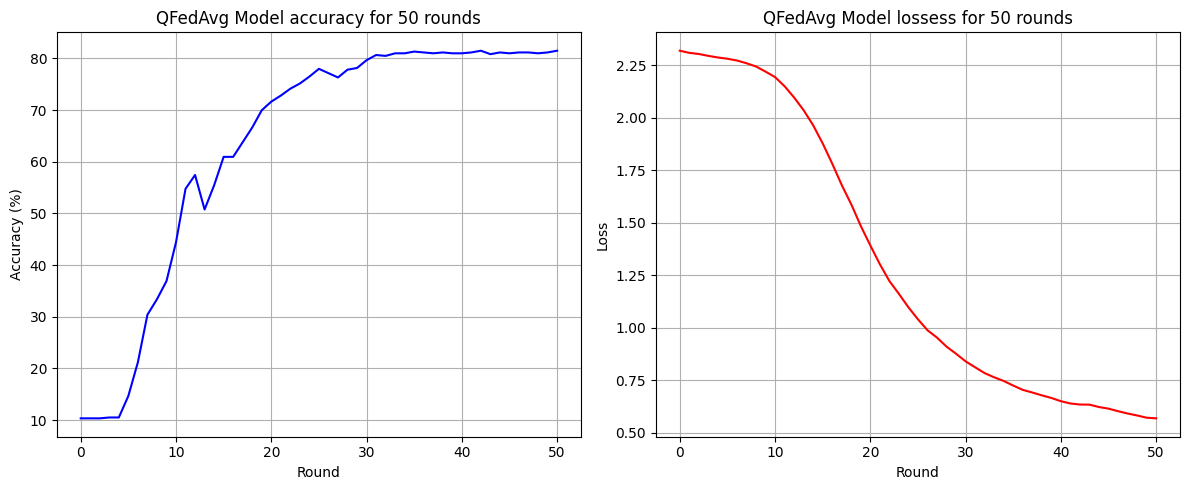

In [13]:
import matplotlib.pyplot as plt

print("Average Accuracy Variance: ", np.mean(np.array(accuray_var_list)))
print("Average Loss Variance: ", np.mean(np.array(loss_var_list)))
print()
# Extract accuracy and loss data
global_accuracy_centralised = history.metrics_centralized["accuracy"]
global_loss_centralised = history.metrics_centralized["loss"]

# Plot accuracy
plt.figure(figsize=(12, 5))  # Adjust the figure size as needed
plt.subplot(1, 2, 1)
round_acc = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]
plt.plot(round_acc, acc, color='b')
plt.xlabel("Round")
plt.ylabel("Accuracy (%)")
plt.title("QFedAvg Model accuracy for 50 rounds")
plt.grid()

# Plot loss
plt.subplot(1, 2, 2)
round_loss = [data[0] for data in global_loss_centralised]
loss = [data[1] for data in global_loss_centralised]
plt.plot(round_loss, loss, color='r')
plt.xlabel("Round")
plt.ylabel("Loss")
plt.title("QFedAvg Model lossess for 50 rounds")
plt.grid()

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [ ]:
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
compute_dp_sgd_privacy.compute_dp_sgd_privacy_statement(
    number_of_examples=60000,
    batch_size=BATCH_SIZE,
    noise_multiplier=SGD_NOISE,
    num_epochs=EPOCHS,
    delta=1e-5,
)

'DP-SGD performed over 60000 examples with 8 examples per iteration, noise\nmultiplier 0.2 for 5 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:       354.861\n    Epsilon assuming Poisson sampling (*):                   5037.128\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed the actual epsilon should be\ncloser to this value than the conservative assumption of an arbitrary data\norder.\n'